
# Sales Predictions using Machine Learning
Notebook by: Omer Hausner
---
---

# 📊 Dataset Overview: Store Sales Forecasting

This dataset contains historic data from **Corporación Favorita**, a large Ecuador-based grocery retailer. The goal is to predict sales for various product families across different stores.

Link to data - [kaggle link](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

---

### 🗂️ Core Files

* **train.csv**: The training data, comprising time series of features `store_nbr`, `family`, and `onpromotion` as well as the target `sales`.
* **sales**: Total sales for a product family. Fractional values are possible (e.g., 1.5 kg of cheese).
* **onpromotion**: Total number of items in a product family being promoted at a store on a given date.


* **test.csv**: The test data. The dates are for the **15 days** after the last date in the training data.
* **stores.csv**: Store metadata, including `city`, `state`, `type`, and `cluster` (a grouping of similar stores).
* **oil.csv**: Daily oil price. Ecuador is an oil-dependent country; its economical health is highly vulnerable to shocks in oil prices.
* **holidays_events.csv**: Holidays and Events metadata.

---

### 🔍 Key Domain Knowledge & Logic

#### 1. Holiday Handling

Special attention must be paid to the **transferred** column:

* **Transferred Holiday**: A holiday that falls on the calendar but was moved by the government. It behaves like a **normal day**.
* **Transfer Type**: Look for rows where type is 'Transfer' to find the day the holiday was actually celebrated.
* **Bridge**: Extra days added to extend a break (long weekends).
* **Work Day**: Days (like Saturdays) meant to "pay back" Bridge days; they behave like regular work days.

#### 2. Socio-Economic Factors

* **Public Sector Wages**: Paid every two weeks on the **15th** and the **last day of the month**. This frequently causes spikes in supermarket sales.
* **Earthquake Impact**: A magnitude 7.8 earthquake struck Ecuador on **April 16, 2016**. Relief efforts and donations greatly affected supermarket sales for several weeks after the event.
* **Oil Dependency**: As an oil-dependent nation, daily fluctuations in oil prices are a leading indicator of consumer spending power.

---

### 📈 Technical Approach

* **Feature Engineering**: Incorporate rolling averages, lags, and slopes to capture momentum.
* **Recursive Forecasting**: Since the test set spans 15 days and relies on lagged features, predictions must be made day-by-day, feeding each day's prediction back into the model as an input for the next day.
* **Scaling**: Numerical features should be Z-score scaled (StandardScaler) to ensure models like Ridge Regression treat all features fairly.

## 📊 Evaluation Metric: RMSLE

The competition uses **Root Mean Squared Logarithmic Error (RMSLE)**. This metric measures the **ratio** between predicted and actual values rather than the absolute difference.

### 📐 The Formula

### 💡 Why RMSLE?

The main idea is to penalize **relative error**. An error of 100 units is "worse" for a small store than for a mega-retailer.

* **Scenario A:** True = 300, Pred = 200 (Error = **100**) → 📉 **High Penalty** (1/3 of total)
* **Scenario B:** True = 1000, Pred = 900 (Error = **100**) → 📉 **Low Penalty** (1/10 of total)

### 🚀 Implementation Strategy

To optimize for this metric:

1. **Log-Transform** the target: `np.log1p(y)` 🪵
2. **Train** the model on the log-scale 🧠
3. **Inverse-Transform** predictions: `np.expm1(y_pred)` to get back to real units 🔄


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge, LinearRegression
from xgboost import XGBRegressor

from tqdm import tqdm

tqdm.pandas()


# Utils

In [3]:
def rmsle_manual(y_true, y_pred):
    """
    Calculates the Root Mean Squared Logarithmic Error (RMSLE).

    Args:
        y_true (pd.Series or np.array): Actual target values.
        y_pred (pd.Series or np.array): Predicted values.

    Returns:
        float: The RMSLE score.
    """
    # Ensure all values are non-negative, as log is used
    if (y_true < 0).any() or (y_pred < 0).any():
        raise ValueError("RMSLE cannot be used when targets contain negative values.")
        
    # Calculate squared logarithmic errors
    squared_log_errors = np.power(np.log(y_pred + 1) - np.log(y_true + 1), 2)
    
    # Calculate the mean of the squared logarithmic errors and take the square root
    rmsle_score = np.sqrt(np.mean(squared_log_errors))
    
    return rmsle_score

In [4]:
def specific_df(df, store, family):
    return df[(df['store_nbr'] == store) & (df['family'] == family)]

In [5]:
# 1. Barplot Function
def plot_categorical_bar(df, category_col, target_col='sales', agg_type='mean', top_k=None, tilt_angle=0):
    """
    Generates a bar plot with value labels.
    - If 'mean': shows the mean with Standard Deviation error bars.
    - If 'sum': shows the total sum (no error bars).
    """
    plt.figure(figsize=(10, 6))
    
    # Define estimator and error bar settings based on user input
    if agg_type == 'mean':
        estimator_func = 'mean'
        error_bar_setting = 'sd' # Standard Deviation
        title_text = f"Mean of {target_col} by {category_col} (with Std Dev)"
    elif agg_type == 'sum':
        estimator_func = 'sum'
        error_bar_setting = None # No error bars for simple sums
        title_text = f"Sum of {target_col} by {category_col}"
    else:
        raise ValueError("agg_type must be either 'mean' or 'sum'")

    order_df = df.groupby(category_col)[target_col].agg(estimator_func).reset_index()
    order_df = order_df.sort_values(target_col, ascending=False)

    if top_k:
            order_df = order_df.head(top_k)

    sort_order = order_df[category_col].tolist()

    # Create the plot
    ax = sns.barplot(
        data=df, 
        x=category_col, 
        y=target_col, 
        estimator=estimator_func, 
        # errorbar=error_bar_setting,
        capsize=0.1, # Adds little caps to the error bars
        palette='viridis',
        order=sort_order
    )

    # Add value labels on top of bars
    for container in ax.containers:
        # We assume the first container holds the bars. 
        # Note: If error bars exist, they are distinct artists, handled automatically by bar_label in newer mpl versions
        ax.bar_label(container, fmt='%.2f', padding=3)

    plt.xticks(rotation=tilt_angle)
    plt.title(title_text)
    plt.ylabel(f"{target_col} ({agg_type})")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# 2. Statistical Test Function
def run_stat_test(df, category_col, target_col='sales'):
    """
    Analyzes the relationship between a categorical and numeric variable.
    - 2 Categories: Independent T-Test
    - >2 Categories: One-way ANOVA
    """
    # Drop NaNs for the calculation
    clean_df = df[[category_col, target_col]].dropna()
    
    # Get unique categories
    groups = clean_df[category_col].unique()
    
    # Create a list of arrays (one for each category)
    group_data = [clean_df[clean_df[category_col] == g][target_col] for g in groups]
    
    print(f"--- Statistical Test: {target_col} by {category_col} ---")
    
    if len(groups) == 2:
        print(f"Detected 2 groups: {groups}. Running T-Test.")
        stat, p_val = stats.ttest_ind(group_data[0], group_data[1])
        test_name = "T-Test"
    elif len(groups) > 2:
        print(f"Detected {len(groups)} groups. Running One-way ANOVA.")
        stat, p_val = stats.f_oneway(*group_data)
        test_name = "ANOVA"
    else:
        print("Error: Need at least 2 categories to perform a statistical test.")
        return None

    # Output results
    print(f"{test_name} Statistic: {stat:.4f}")
    print(f"P-Value: {p_val:.4e}")
    
    if p_val < 0.05:
        print("Result: Significant difference (p < 0.05)")
    else:
        print("Result: No significant difference (p >= 0.05)")
        
    return stat, p_val

# 3. Scatter Plot Function
def plot_scatter(df, x_col, y_col, heat_col=None):
    plt.figure(figsize=(10, 6))

    plt.scatter(df[x_col], df[y_col], c=df[heat_col] if heat_col else None, cmap='viridis')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    # Move legend outside if crowded
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def density_plot(df, y_col):
    mean = df[y_col].mean()
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[y_col], shade=True)
    plt.xlabel(y_col)
    plt.ylabel("Density")
    plt.axvline(mean, color='red', linestyle='--', label=f"Mean: {mean:.2f}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.title(f"Density Plot: {y_col}")
    plt.tight_layout()
    plt.show()

def boxplot(df, y_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[y_col])
    plt.xlabel(y_col)
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.title(f"Boxplot: {y_col}")
    plt.tight_layout()
    plt.show()

In [6]:
# 4. Timeline Plot Function
def plot_timeline(df, time_col, target_col, category_col=None, rolling_window=0):
    """
    Plots a target variable over time.
    - If category_col is provided: plots multiple lines (one per category).
    - Automatically sorts by time_col to prevent "zigzag" lines.
    """
    plt.figure(figsize=(12, 6))
    
    # Sort data by time to ensure the line flows correctly from left to right
    df_sorted = df.sort_values(by=time_col)
    
    if rolling_window > 0:
        df_sorted[target_col] = df_sorted[target_col].rolling(rolling_window).mean()

    sns.lineplot(
        data=df_sorted,
        x=time_col,
        y=target_col,
        hue=category_col,       # Optional category split
        # marker='o',             # Adds dots to data points for visibility
        palette='tab10' if category_col else None
    )
    
    title = f"Timeline: {target_col} over {time_col}"
    if category_col:
        title += f" (grouped by {category_col})"
        
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# 5. Time-Series Decomposition Function
def plot_ts_decomposition(df, time_col, target_col, period=7, model='additive'):
    """
    Decomposes a time series into Trend, Seasonality, and Residuals.
    
    Parameters:
    - period: The frequency of the data (e.g., 12 for monthly, 7 for daily, 4 for quarterly).
    - model: 'additive' or 'multiplicative'. 
      Use 'additive' if the magnitude of seasonality is constant.
      Use 'multiplicative' if seasonality increases as the trend increases.
    """
    # Prepare data: Set time as index and sort
    # We create a copy to avoid modifying the original dataframe outside the function
    ts_data = df.copy()
    
    # Ensure time_col is datetime objects (optional but recommended for real dates)
    # If your input is just numbers (1, 2, 3...), this step is skipped automatically.
    if pd.api.types.is_string_dtype(ts_data[time_col]):
         ts_data[time_col] = pd.to_datetime(ts_data[time_col])
         
    ts_data = ts_data.set_index(time_col).sort_index()
    
    # Check for missing values which break decomposition
    if ts_data[target_col].isnull().any():
        print("Warning: Missing values detected. Interpolating linearly.")
        ts_data[target_col] = ts_data[target_col].interpolate(method='linear')

    # Perform Decomposition
    print(f"Running decomposition (Period={period}, Model={model})...")
    decomposition = seasonal_decompose(ts_data[target_col], model=model, period=period)
    
    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    decomposition.observed.plot(ax=ax1, title='Observed (Original Data)', color='black')
    decomposition.trend.plot(ax=ax2, title='Trend', color='blue')
    decomposition.seasonal.plot(ax=ax3, title='Seasonality', color='green')
    decomposition.resid.plot(ax=ax4, title='Residuals (Noise)', color='red', marker='o', linestyle='None')
    
    plt.tight_layout()
    plt.show()

def aggregate_for_time_series(df, time_col, target_col, method='mean'):
    """
    Groups data by time_col and aggregates the target_col.
    method: 'mean' (for averages) or 'sum' (for totals like total revenue).
    """
    if method == 'mean':
        # Useful for things like 'Average Price' or 'Temperature'
        df_agg = df.groupby(time_col)[target_col].mean().reset_index()
    elif method == 'sum':
        # Useful for 'Total Sales' or 'Total Clicks'
        df_agg = df.groupby(time_col)[target_col].sum().reset_index()
    
    return df_agg



In [7]:
def fill_missing_dates(df, date_col, category_cols, target_col='sales', fill_value=0):
    """
    Ensures the dataframe has a continuous timeline for every group.
    - category_cols: List of columns defining the groups (e.g. ['Store', 'Category'])
    """
    # 1. Convert to datetime if needed
    df[date_col] = pd.to_datetime(df[date_col])
    
    # 2. Get the full range of dates (Min date to Max date)
    # This automatically includes Dec 12th and any other gaps
    full_dates = pd.date_range(start=df[date_col].min(), 
                               end=df[date_col].max(), 
                               freq='D')
    
    print(f"Filling missing dates from {full_dates.min().date()} to {full_dates.max().date()}")
    
    # 3. Get unique values for your groups (Store, Category, etc.)
    unique_groups = [df[c].unique() for c in category_cols]
    
    # 4. Create the "Master Index" (Cartesian Product)
    # This creates every possible combination of Date + Store + Category
    # structure: [Dates] x [Stores] x [Categories]
    iterables = [full_dates] + unique_groups
    multi_index = pd.MultiIndex.from_product(iterables, names=[date_col] + category_cols)
    
    dates_missing = full_dates.difference(df[date_col].unique())
    print(f"Missing dates to be filled: {dates_missing.date.tolist()}")
    # 5. Reindex the dataframe
    # We set the index to match our Master Index, then reindex.
    # 'fill_value=0' puts a 0 where data was missing (e.g., Dec 12)
    df_filled = df.set_index([date_col] + category_cols)\
                  .reindex(multi_index)\
                  .reset_index()
    df_filled[target_col] = df_filled[target_col].fillna(fill_value)
    
    return df_filled


In [8]:
# 1. Feature Engineering Function (Your Logic Encapsulated)
def engineer_features(df_in):
    """
    Applies the specific rolling/lag logic provided by the user.
    """
    df = df_in.copy()
    
    # --- A. Family Level Features ---
    # Note: We must maintain the index or merge carefully. 
    # The safest way in a loop is to calculate on the full temp DF and return columns.
    
    # 1. Rolling mean of sales per family
    # (We group by date+family first to get daily family totals, then calc lags)
    family_daily = df.groupby(['date', 'family'])['sales'].mean().reset_index()
    
    # Calculate the LAGS (Shift 1)
    family_daily['sales_last_day_family'] = family_daily.groupby('family')['sales'].transform(lambda x: x.shift(1))
    
    # Now calculate rolling on the LAGGED value (to avoid leakage)
    # Note: Your original logic used transform on 'sales_last_day_family', which is correct for recursion
    grouper = family_daily.groupby('family')['sales_last_day_family']
    
    family_daily['rolling_mean_family_7'] = grouper.transform(lambda x: x.rolling(7).mean())
    family_daily['rolling_mean_family_30'] = grouper.transform(lambda x: x.rolling(30).mean())
    family_daily['sales_week_ago_family'] = grouper.transform(lambda x: x.shift(7))
    family_daily['sales_month_ago_family'] = grouper.transform(lambda x: x.shift(30))
    
    # Ratios / Slopes (Handle division by zero if necessary, usually np.inf or NaN)
    family_daily['weekly_change_family'] = family_daily['sales_last_day_family'] / family_daily['sales_week_ago_family']
    family_daily['weekly_slope_family'] = (family_daily['sales_last_day_family'] - family_daily['sales_week_ago_family']) / 7
    family_daily['monthly_slope_family'] = (family_daily['sales_last_day_family'] - family_daily['sales_month_ago_family']) / 30
    
    # Merge back to main df
    df = df.merge(family_daily.drop(columns=['sales']), on=['date', 'family'], how='left')

    # --- B. Store-Family Level Features ---
    store_family_daily = df.groupby(['date', 'store_nbr', 'family'])['sales'].mean().reset_index()
    store_family_daily['sales_last_day_store_family'] = store_family_daily.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1))
    
    grouper_sf = store_family_daily.groupby(['store_nbr', 'family'])['sales_last_day_store_family']
    
    store_family_daily['rolling_mean_store_family_7'] = grouper_sf.transform(lambda x: x.rolling(7).mean())
    store_family_daily['rolling_mean_store_family_30'] = grouper_sf.transform(lambda x: x.rolling(30).mean())
    store_family_daily['sales_week_ago_store_family'] = grouper_sf.transform(lambda x: x.shift(7))
    store_family_daily['sales_month_ago_store_family'] = grouper_sf.transform(lambda x: x.shift(30))
    
    store_family_daily['weekly_change_store_family'] = store_family_daily['sales_last_day_store_family'] / store_family_daily['sales_week_ago_store_family']
    store_family_daily['weekly_slope_store_family'] = (store_family_daily['sales_last_day_store_family'] - store_family_daily['sales_week_ago_store_family']) / 7
    store_family_daily['monthly_slope_store_family'] = (store_family_daily['sales_last_day_store_family'] - store_family_daily['sales_month_ago_store_family']) / 30

    df = df.merge(store_family_daily.drop(columns=['sales']), on=['date', 'store_nbr', 'family'], how='left')

    # --- C. Store Level Features ---
    store_daily = df.groupby(['date', 'store_nbr'])['sales'].mean().reset_index()
    store_daily['sales_last_day_store'] = store_daily.groupby('store_nbr')['sales'].transform(lambda x: x.shift(1))
    
    grouper_s = store_daily.groupby('store_nbr')['sales_last_day_store']
    
    store_daily['rolling_mean_store_7'] = grouper_s.transform(lambda x: x.rolling(7).mean())
    store_daily['rolling_mean_store_30'] = grouper_s.transform(lambda x: x.rolling(30).mean())
    store_daily['sales_week_ago_store'] = grouper_s.transform(lambda x: x.shift(7))
    store_daily['sales_month_ago_store'] = grouper_s.transform(lambda x: x.shift(30))
    
    store_daily['weekly_change_store'] = store_daily['sales_last_day_store'] / store_daily['sales_week_ago_store']
    store_daily['weekly_slope_store'] = (store_daily['sales_last_day_store'] - store_daily['sales_week_ago_store']) / 7
    store_daily['monthly_slope_store'] = (store_daily['sales_last_day_store'] - store_daily['sales_month_ago_store']) / 30

    df = df.merge(store_daily.drop(columns=['sales']), on=['date', 'store_nbr'], how='left')
    
    return df

In [9]:
def prepare_and_fit_train(model, train_df, categorical_features=[], 
                          numerical_features=[], 
                          target_col='sales', 
                          feature_selection=False, 
                          rmsle_metric=True):

    """ train_df should include all engineered features"""

    X_train = train_df[categorical_features + numerical_features]
    y_train = train_df[target_col]

    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train.fillna(0, inplace=True)

    cols_to_min_max = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter']
    cols_not_scale = ['month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'quarter_sin', 'quarter_cos']
    cols_to_z_normalize = [col for col in numerical_features if col not in (cols_not_scale+cols_to_min_max)]
    
    minmax_scaler = MinMaxScaler()
    X_train[cols_to_min_max] = minmax_scaler.fit_transform(X_train[cols_to_min_max])

    z_scaler = StandardScaler()
    X_train[cols_to_z_normalize] = z_scaler.fit_transform(X_train[cols_to_z_normalize])


    X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)

    if rmsle_metric:
        y_train = np.log1p(y_train)
        
    if feature_selection:
        # categorical_features = [x for x in categorical_features if x in feature_selection]
        # numerical_features = [x for x in numerical_features if x in feature_selection]
        # cols_to_min_max = [x for x in cols_to_min_max if x in feature_selection]
        # cols_to_z_normalize = [x for x in cols_to_z_normalize if x in feature_selection]
        X_train = X_train[feature_selection]
    
    model.fit(X_train, y_train)

    predictions = np.clip(model.predict(X_train), 0, None) # Clip negative predictions to 0.0
    results = pd.DataFrame({'actual': y_train, 'predicted': predictions, 'date': train_df['date']})

    ## We know that sales on January 1st and December 25th are 0 for all stores and categories.
    januaries_1st = ["2015-01-01", "2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"]
    christmans_dates = ["2015-12-25", "2016-12-25", "2017-12-25", "2018-12-25", "2019-12-25"]
    results.loc[(results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
    corrected_predictions = results['predicted']

    if rmsle_metric:
        y_train = np.expm1(y_train)
        corrected_predictions = np.expm1(corrected_predictions)

    print(f"Train RMSLE: {rmsle_manual(y_train, corrected_predictions)}")
    print(f"Train RMSE: {root_mean_squared_error(y_train, corrected_predictions)}")
    print(f"Train MAE: {mean_absolute_error(y_train, corrected_predictions)}")

    return model, minmax_scaler, z_scaler, X_train.columns

    

In [10]:
def predict_test(trained_model, minmax_scaler, z_scaler, test_df, train_df, X_cols, categorical_features=[], numerical_features=[], 
                 target_col='sales', feature_selection=False,
                 rmsle_metric=True):
    
    dates_to_predict = sorted(test_df['date'].unique())
    dates_trained_on = sorted(train_df['date'].unique())
    history_dates_to_use = dates_trained_on[-35:]

    cols_to_min_max = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter']
    cols_not_scale = ['month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'quarter_sin', 'quarter_cos']
    cols_to_z_normalize = [col for col in numerical_features if col not in (cols_not_scale+cols_to_min_max)]

    columns = test_df.columns
    history_data = train_df[train_df['date'].isin(history_dates_to_use)][columns]

    predicted_results_list = []

    for current_date in tqdm(dates_to_predict, desc='Predicting test set'):
        # print(f'Preparing data for date: {current_date.date()}')
        current_date_data = test_df[test_df['date']==current_date]
        current_date_data.drop(columns=['id'], inplace=True, errors='ignore')
        
        engineered_df = pd.concat([history_data, current_date_data], axis=0)
        engineered_df = engineer_features(engineered_df)
        engineered_test = engineered_df[engineered_df['date']==current_date]
    

        X_test = engineered_test[categorical_features + numerical_features]
        y_test = engineered_test[target_col]

        X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_test.fillna(0, inplace=True)
        X_test[cols_to_min_max] = minmax_scaler.transform(X_test[cols_to_min_max])

        X_test[cols_to_z_normalize] = z_scaler.transform(X_test[cols_to_z_normalize])

        X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
        X_test = X_test.reindex(columns=X_cols, fill_value=0)

        if feature_selection:
            # categorical_features = [x for x in categorical_features if x in feature_selection]
            # numerical_features = [x for x in numerical_features if x in feature_selection]
            # cols_to_min_max = [x for x in cols_to_min_max if x in feature_selection]
            # cols_to_z_normalize = [x for x in cols_to_z_normalize if x in feature_selection]
            X_test = X_test[feature_selection]        

        # print(f'Predicting sales for date: {current_date.date()}')
        test_predictions = np.clip(trained_model.predict(X_test), 0, None) # Clip negative predictions to 0.0
        test_results = pd.DataFrame({'actual': y_test, 'predicted': test_predictions, 'date': [current_date] * len(test_predictions)})
        januaries_1st = ["2015-01-01", "2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"]
        christmans_dates = ["2015-12-25", "2016-12-25", "2017-12-25", "2018-12-25", "2019-12-25"]
        test_results.loc[(test_results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
        corrected_test_predictions = test_results['predicted']
        
        history_data = pd.concat([history_data, current_date_data], axis=0)
        new_dates_of_history = history_data['date'].unique()[-35:]
        history_data = history_data[history_data['date'].isin(new_dates_of_history)]
        predicted_results_list.extend(corrected_test_predictions.tolist())
        # print(f"num predictions is {len(predicted_results_list)}")

    if rmsle_metric:
        predicted_results_list = np.expm1(np.array(predicted_results_list))
    else:
        predicted_results_list = np.array(predicted_results_list)

    print(f"Test RMSLE: {rmsle_manual(test_df[target_col], predicted_results_list)}")
    print(f"Test RMSE: {root_mean_squared_error(test_df[target_col], predicted_results_list)}")
    print(f"Test MAE: {mean_absolute_error(test_df[target_col], predicted_results_list)}")
    
    return predicted_results_list

In [11]:
def add_time_features(data):
    # Engineer features
    data['date'] = pd.to_datetime(data['date'])

    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['dayofyear'] = data['date'].dt.dayofyear
    data['quarter'] = data['date'].dt.quarter

    data['is_weekend'] = data['dayofweek'].isin([5,6])
    data['is_holiday'] = data['type_holiday'].apply(lambda x: 1 if x != 'None' else 0)
    cyclic_cols = {'month': 12, 'dayofweek': 6, 'quarter': 4}

    data['is_first_january'] = (data['month'] == 1) & (data['day'] == 1)

    for feat in cyclic_cols.keys():
        data[f'{feat}_sin'] = np.sin(2 * np.pi * data[feat] / cyclic_cols[feat])
        data[f'{feat}_cos'] = np.cos(2 * np.pi * data[feat] / cyclic_cols[feat])

    return data
        

# Read Data

In [12]:
train_df = pd.read_csv('store-sales-time-series-forecasting/train.csv')
train_df['date'] = pd.to_datetime(train_df['date'])

oil_df = pd.read_csv('store-sales-time-series-forecasting/oil.csv')
oil_df['date'] = pd.to_datetime(oil_df['date'])

holiday_events_df = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv')
holiday_events_df['date'] = pd.to_datetime(holiday_events_df['date'])

stores_df = pd.read_csv('store-sales-time-series-forecasting/stores.csv')


In [13]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [14]:
full_train_df = fill_missing_dates(train_df, 'date', ['store_nbr', 'family'], fill_value=0)


Filling missing dates from 2013-01-01 to 2017-08-15
Missing dates to be filled: [datetime.date(2013, 12, 25), datetime.date(2014, 12, 25), datetime.date(2015, 12, 25), datetime.date(2016, 12, 25)]


💡Only Christmas eve days are missing in the data, suggesting that stores were closed and therefore no sales were recorded. The function `fill_missing_dates` added the missing dates per store and item family that were missing, and filled 0 on sales for these days.

In [15]:
full_train_df.head()

,date,store_nbr,family,id,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0
1,2013-01-01,1,BABY CARE,1.0,0.0,0.0
2,2013-01-01,1,BEAUTY,2.0,0.0,0.0
3,2013-01-01,1,BEVERAGES,3.0,0.0,0.0
4,2013-01-01,1,BOOKS,4.0,0.0,0.0


In [16]:
# oil_df --> Daily oil price. 
# Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [17]:
holiday_events_df.columns = ['date', 'type_holiday', 'locale_holiday', 'locale_name_holiday', 'description', 'transferred_holiday']
holiday_events_df.head()

,date,type_holiday,locale_holiday,locale_name_holiday,description,transferred_holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [18]:
stores_df.columns = ['store_nbr', 'city', 'state', 'type_store', 'cluster_store']
stores_df.head()


,store_nbr,city,state,type_store,cluster_store
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
stores_df['state'].unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [20]:
len(holiday_events_df)

350

In [21]:
holiday_events_df[holiday_events_df['locale_holiday']=='National']

,date,type_holiday,locale_holiday,locale_name_holiday,description,transferred_holiday
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


👉 We now pre-process the holiday_events_df to separate between local, regional and national holidays, each may have a different effect on sales.

In [22]:
city_holidays = holiday_events_df[holiday_events_df['locale_holiday'] == 'Local']
regional_holidays = holiday_events_df[holiday_events_df['locale_holiday'] == 'Regional']
national_holidays = holiday_events_df[holiday_events_df['locale_holiday'] == 'National']


In [23]:
city_holidays = city_holidays.drop_duplicates(subset=['date', 'locale_name_holiday'], keep='first')
regional_holidays = regional_holidays.drop_duplicates(subset=['date', 'locale_name_holiday'], keep='first')
national_holidays = national_holidays.drop_duplicates(subset=['date'], keep='first')

## Create Merged Training DF

👉 To further explore the data, and later on training machine learning models to predict sales, I am merging the sales table with every other relevant table.

In [24]:
train_df_merged = full_train_df.merge(stores_df, how='left', on='store_nbr')\
    .merge(oil_df, how='left', on='date')\
            .merge(city_holidays, how='left', left_on=['date', 'city'], right_on=['date', 'locale_name_holiday'])\
            .merge(regional_holidays, how='left', left_on=['date', 'state'], right_on=['date', 'locale_name_holiday'])\
            .merge(national_holidays, how='left', on=['date'])

train_df_merged.set_index('id', inplace=True)
train_df_merged.reset_index(inplace=True)

In [25]:
cols_to_drop = ['id', 'description','description_x', 'description_y', 'type_holiday_x', 'type_holiday_y', 'locale_holiday_x', 'locale_holiday_y', 'locale_name_holiday_x', 'locale_name_holiday_y', 'transferred_holiday_x', 'transferred_holiday_y']
train_df_merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [26]:
holiday_cols = ['type_holiday', 'locale_holiday', 'locale_name_holiday', 'transferred_holiday']
train_df_merged.loc[:,holiday_cols] = train_df_merged.loc[:,holiday_cols].fillna('None')

In [27]:
# Result of above steps
train_df_merged.head()

,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster_store,dcoilwtico,type_holiday,locale_holiday,locale_name_holiday,transferred_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False


In [28]:
print(f"train_df_merged did not lose rows from initial full_train_df: {len(full_train_df) == len(train_df_merged)}")

train_df_merged did not lose rows from initial full_train_df: True


## Split train and test for validation

👉 We now create a test subset consists of `days_for_test = 16` of the data's last days, to serve as the test subset.

In [29]:
# set num of last days in data to serve as test set
days_for_test = 16

# 2. Calculate the cutoff date (Max Date minus 90 Days)
cutoff_date = train_df_merged['date'].max() - pd.Timedelta(days=days_for_test)

# 3. Split using simple comparison
# Train: Everything UP TO the cutoff
new_train_df = train_df_merged[train_df_merged['date'] <= cutoff_date]

# Test: Everything AFTER the cutoff
test_df = train_df_merged[train_df_merged['date'] > cutoff_date]

print(f"Training Data Ends: {new_train_df['date'].max()}")
print(f"Test Data Starts:   {test_df['date'].min()}")

Training Data Ends: 2017-07-30 00:00:00
Test Data Starts:   2017-07-31 00:00:00


# EDA

✨ The main purpose of this section is to get to know the different columns in our data, and mainly examine relations with the sales target value.

For **categorical columns**, I will examine their cardinality, and values included, and use a barplot to see the **average daily sales** per categorical value (sorted in a decreasing order). 

For **continuous columns**, I will use a scatter plot to see their association with **average daily sales**.

In [ ]:
new_train_df.isna().sum()

date                        0
store_nbr                   0
family                      0
sales                       0
onpromotion              7128
city                        0
state                       0
type_store                  0
cluster_store               0
dcoilwtico             883872
type_holiday                0
locale_holiday              0
locale_name_holiday         0
transferred_holiday         0
dtype: int64

In [ ]:
min_period = new_train_df['date'].min()
max_period = new_train_df['date'].max()
print(f'Data presents sales from {min_period} to {max_period}')
print(f'Shape of the training data - {new_train_df.shape[0]} rows, {new_train_df.shape[1]} columns')

Data presents sales from 2013-01-01 00:00:00 to 2017-05-17 00:00:00
Shape of the training data - 2847636 rows, 14 columns


👉 Let's check missing data of column `onpromotion`:

In [ ]:
new_train_df[new_train_df['onpromotion'].isna()]['date'].unique()

<DatetimeArray>
['2013-12-25 00:00:00', '2014-12-25 00:00:00', '2015-12-25 00:00:00',
 '2016-12-25 00:00:00']
Length: 4, dtype: datetime64[ns]

💡We see that the missing values are the result of the same christmas days which we imputed. We will set these missing values to 0.

In [ ]:
new_train_df['onpromotion'] = new_train_df['onpromotion'].fillna(0)

In [ ]:
new_train_df.isna().sum()

date                        0
store_nbr                   0
family                      0
sales                       0
onpromotion                 0
city                        0
state                       0
type_store                  0
cluster_store               0
dcoilwtico             883872
type_holiday                0
locale_holiday              0
locale_name_holiday         0
transferred_holiday         0
dtype: int64

❗Regarding missing values of `dcoilwtico` we will decide on its imputation after analysing this feature's behavior.


### Analysis of `family` (= item category)

In [ ]:
num_categories = new_train_df['family'].nunique()
list_categories = new_train_df['family'].unique()

print(f'Number of categories: {num_categories}')
print(f'List of categories: {list_categories}')

Number of categories: 33
List of categories: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [ ]:
new_train_df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster_store,dcoilwtico,type_holiday,locale_holiday,locale_name_holiday,transferred_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False


In [ ]:
new_train_df.reset_index(inplace=True)
new_train_df.index.duplicated().sum()

np.int64(0)

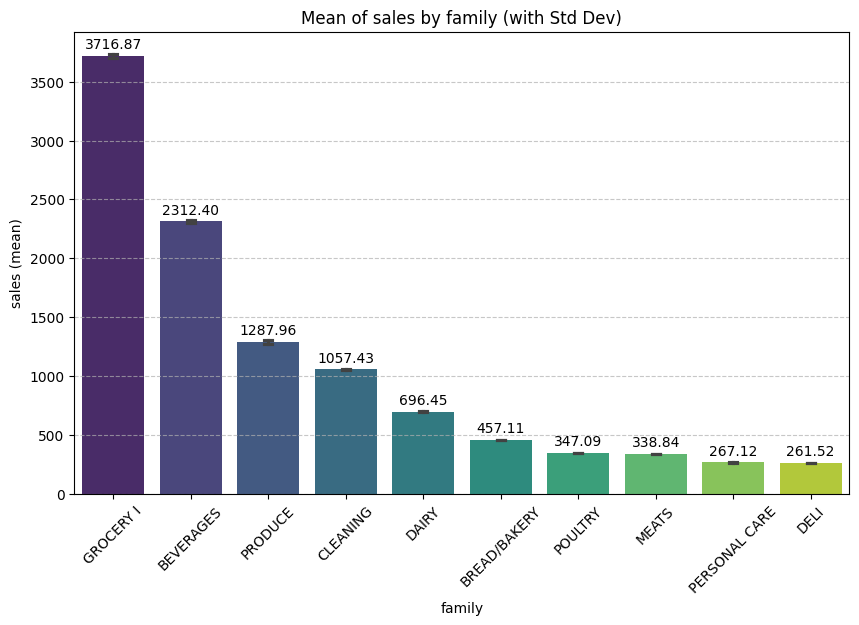

In [ ]:
plot_categorical_bar(new_train_df, 'family', target_col='sales', agg_type='mean', top_k=10, tilt_angle=45)

In [ ]:
new_train_df.groupby('family')['sales'].mean().sort_values(ascending=False).head(15)

family
GROCERY I           3716.873997
BEVERAGES           2312.404383
PRODUCE             1287.955629
CLEANING            1057.433401
DAIRY                696.450447
BREAD/BAKERY         457.108285
POULTRY              347.087676
MEATS                338.838892
PERSONAL CARE        267.118412
DELI                 261.523238
EGGS                 169.333808
HOME CARE            168.510951
FROZEN FOODS         155.520424
PREPARED FOODS        96.893645
LIQUOR,WINE,BEER      84.403525
Name: sales, dtype: float64

💡 Item category shows to have a great association with the sales --> `GROCERY I` shows to be the item category with the highest sales.

## Analysis of `onpromotion`

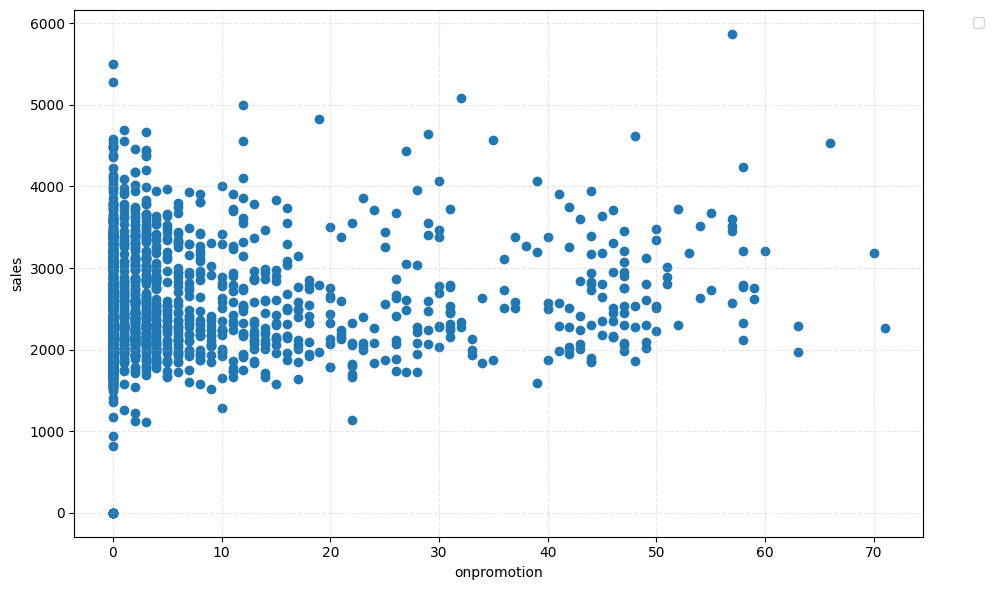

In [ ]:
plot_scatter(new_train_df[(new_train_df['family']=='CLEANING')&(new_train_df['store_nbr']==44)], 'onpromotion', 'sales')

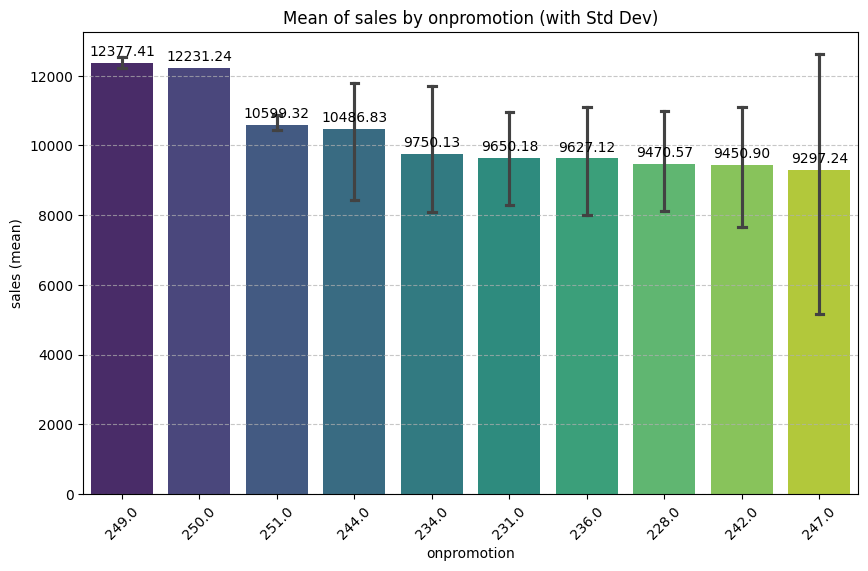

In [ ]:
plot_categorical_bar(new_train_df, 'onpromotion', target_col='sales', agg_type='mean', top_k=10, tilt_angle=45)

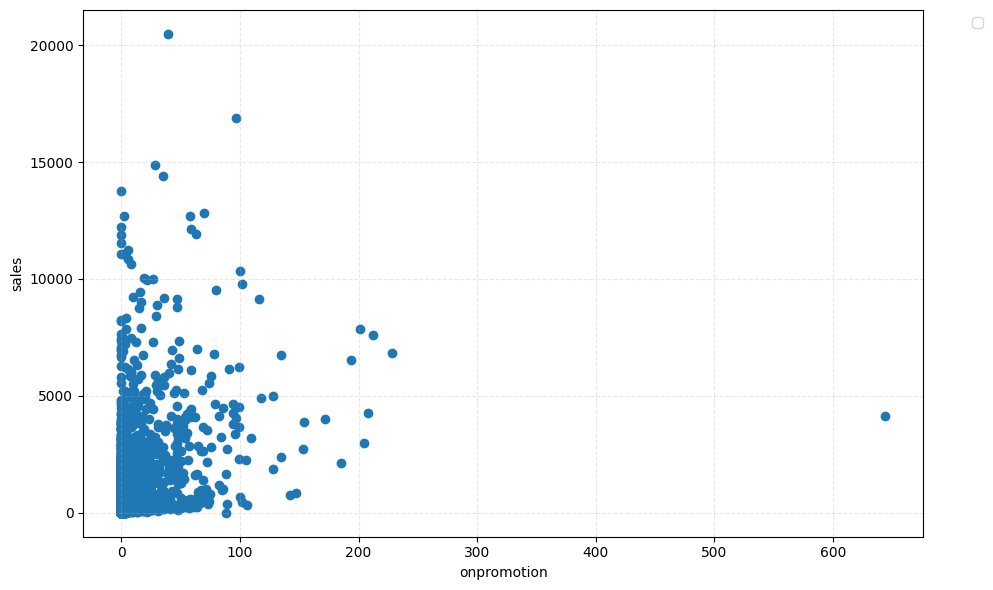

In [ ]:
plot_scatter(new_train_df.sample(10_000), 'onpromotion', 'sales')

In [ ]:
np.corrcoef(new_train_df['onpromotion'], new_train_df['sales'])[0][1]

np.float64(0.411405901496279)

💡`onpromotion` alone shows strong correlation with the sales - with Pearson Correlation value of 0.4.

## Analysis of `Store`

In [ ]:
num_stores = new_train_df['store_nbr'].nunique()
list_stores = new_train_df['store_nbr'].unique()

print(f'Number of stores: {num_stores}')
print(f'List of stores: {list_stores}')

Number of stores: 54
List of stores: [ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]


In [ ]:
stores_df.columns

Index(['store_nbr', 'city', 'state', 'type_store', 'cluster_store'], dtype='object')

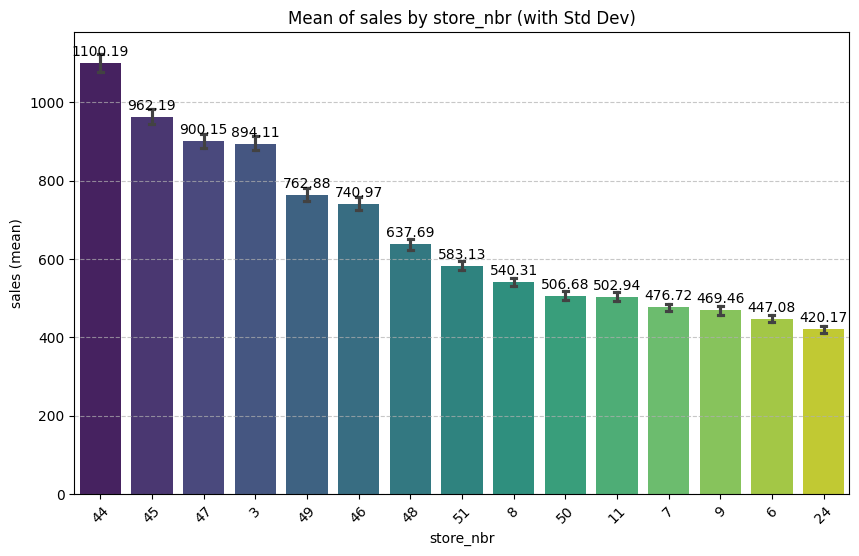

In [ ]:
plot_categorical_bar(new_train_df, 'store_nbr', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

In [ ]:
new_train_df['store_nbr'].value_counts().unique()

array([52734])

💡 Store id shows to have a great association with the sales --> `store 44` shows to be the store with highest sales in the period of data.
It is assumed that both `store id` and `item family` will have a major impact on sales in this prediction task. 

## Analysis of `type_store`

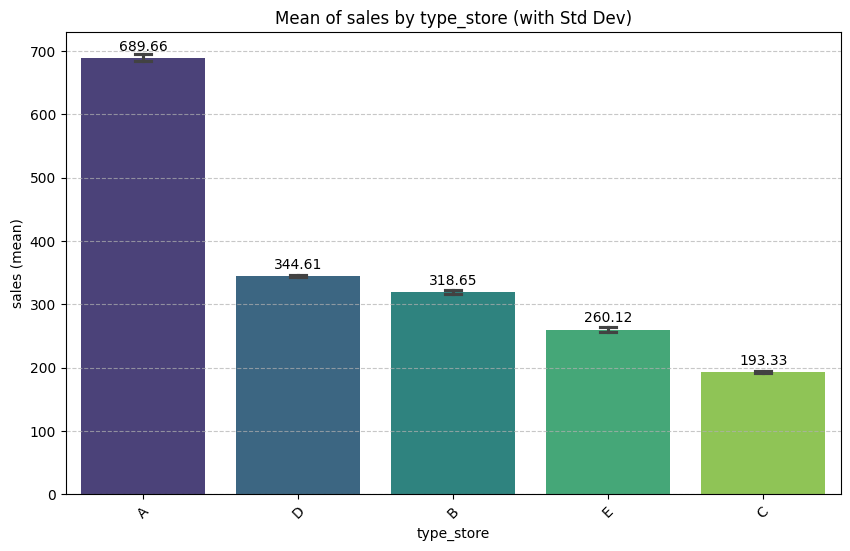

In [ ]:
plot_categorical_bar(new_train_df, 'type_store', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 type of store shows strog association with sales, where `store type A` associates with highest sales, about twice as much as the second highest sales store type.

## Analysis of `cluster_store`

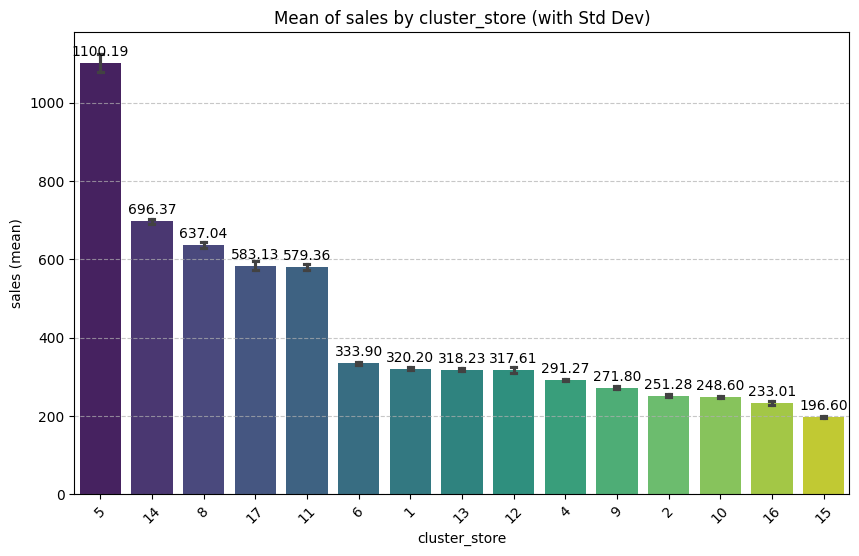

In [ ]:
plot_categorical_bar(new_train_df, 'cluster_store', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 Cluster is also a strong association feature, where cluster number 5 is with the highest.

## Analysis of `city`

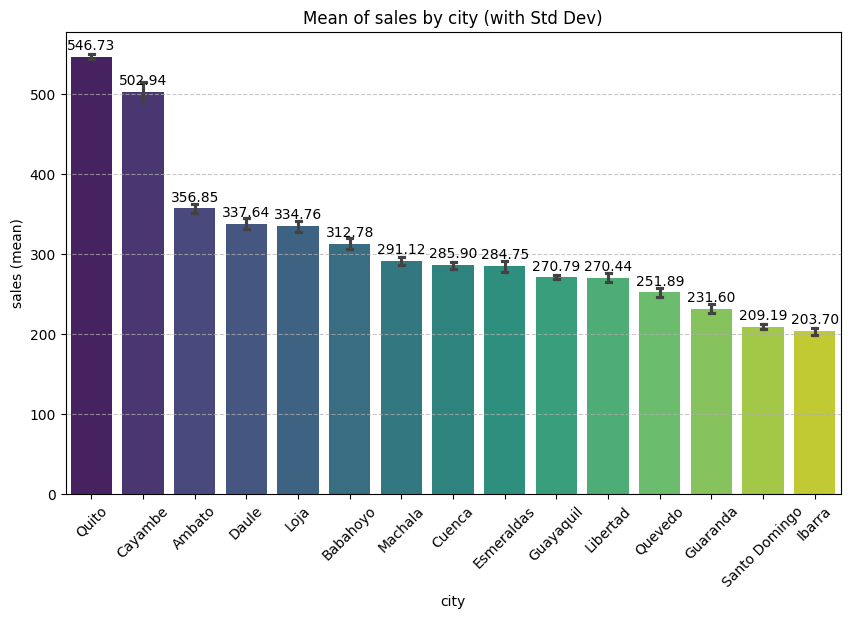

In [ ]:
plot_categorical_bar(new_train_df, 'city', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 Good feature!

## Analysis of `state`

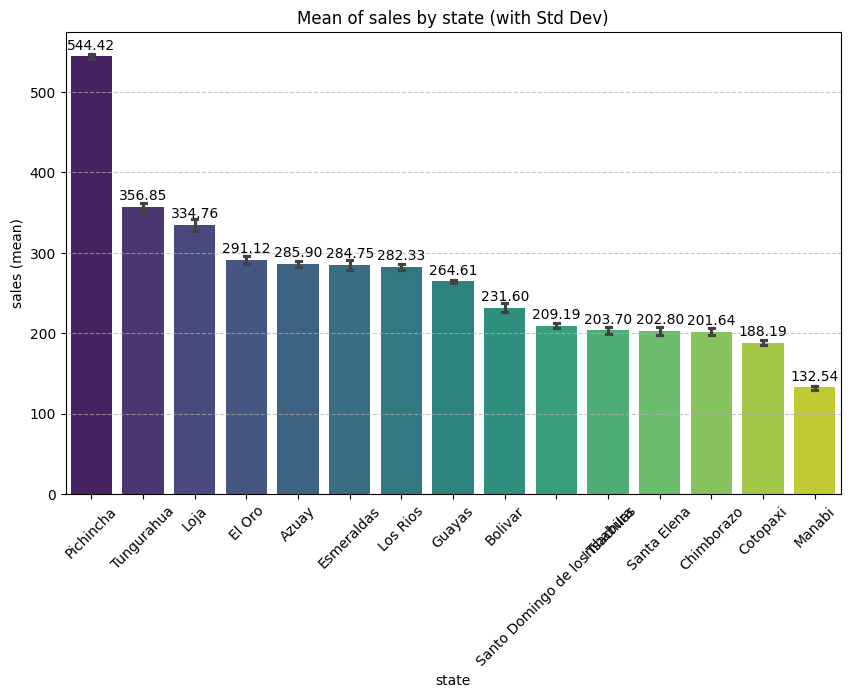

In [ ]:
plot_categorical_bar(new_train_df, 'state', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 Good feature!

## Analysis of `type_holiday`

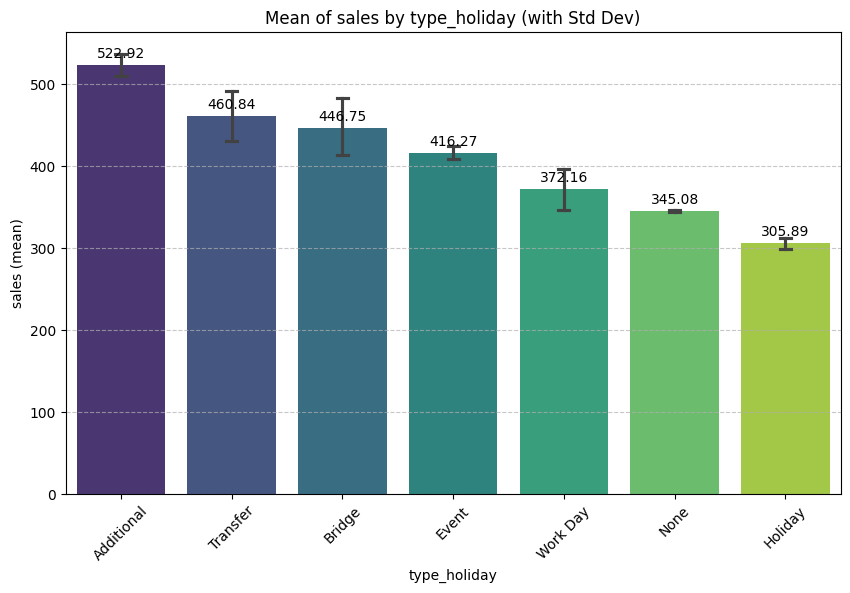

In [ ]:
plot_categorical_bar(new_train_df, 'type_holiday', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 Good feature!

## Analysis of `locale_holiday`

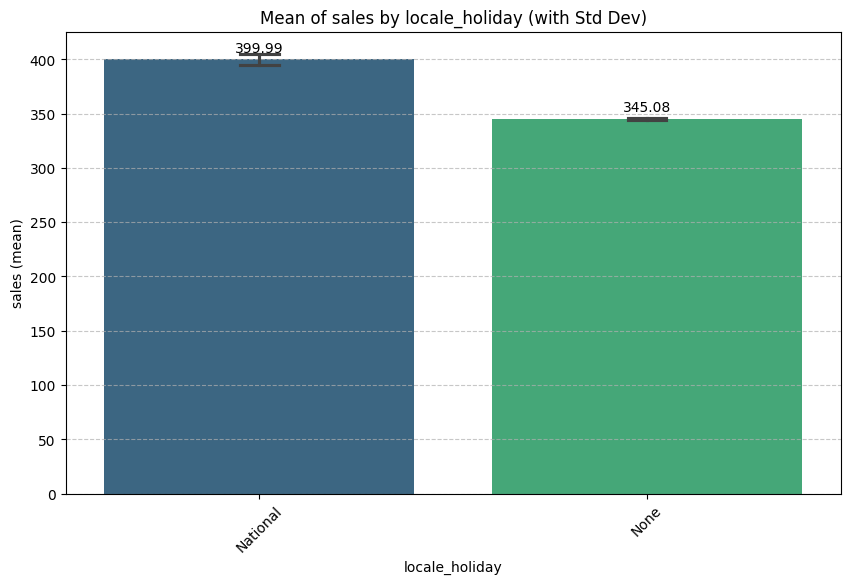

In [ ]:
plot_categorical_bar(new_train_df, 'locale_holiday', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 Interesting to see that local holidays associates with highest sales, rather than national holidays. I initially thought that national holidays would be stronger in sales, but I learned otherwise. It might be that local holidays are more celebrative amongs locals and therefore it becomes a more festive occasion, with maybe more discounts and more opportunities to buy. 

## Analysis of `transferred_holiday`

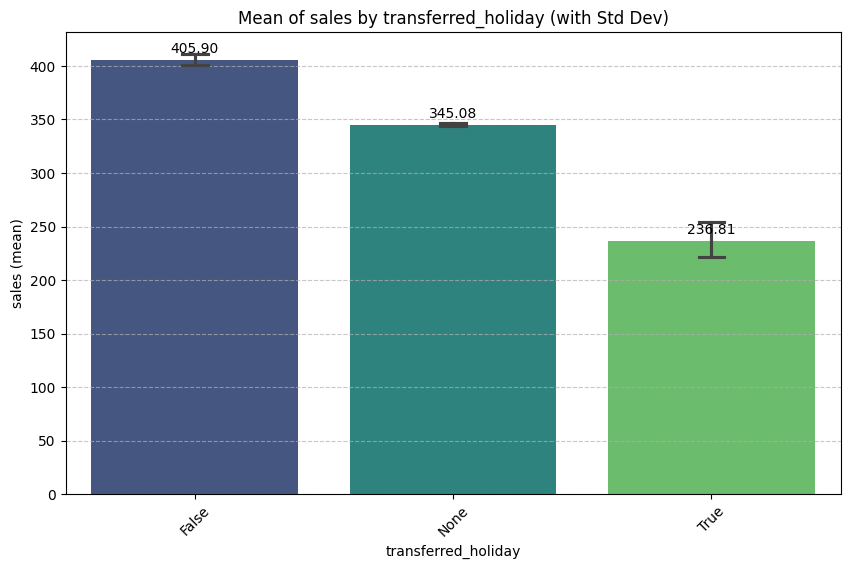

In [ ]:
plot_categorical_bar(new_train_df, 'transferred_holiday', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

## Analysis of `dcoilwtico`

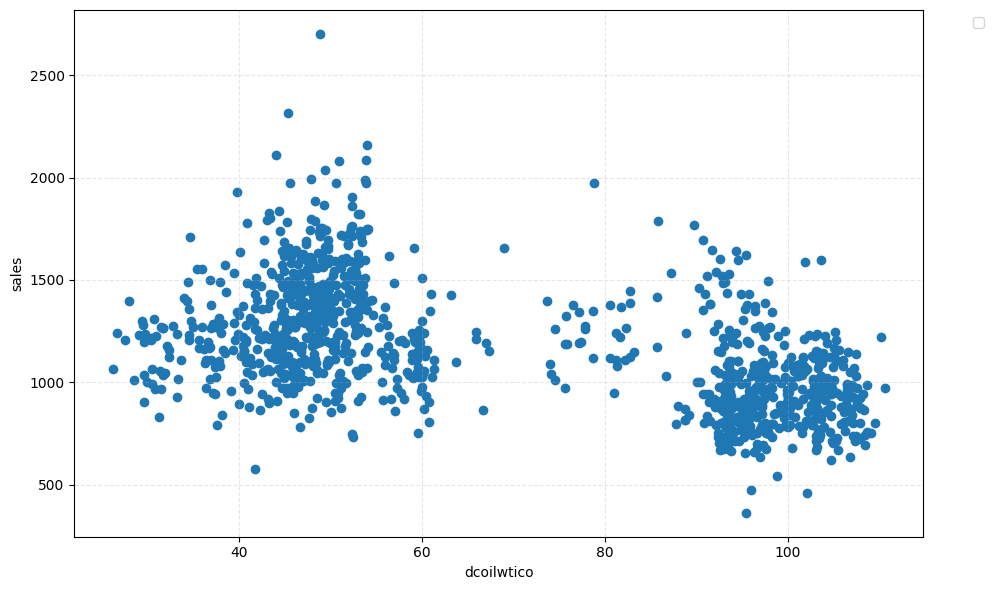

In [ ]:
plot_scatter(new_train_df[(new_train_df['store_nbr']==44)&(new_train_df['family']=='BREAD/BAKERY')], 'dcoilwtico', 'sales')

In [ ]:
new_train_df[['dcoilwtico', 'sales']].corr().iloc[0][1]

np.float64(-0.07841341907916469)

💡 Oil prices does not seem to be highly associated with sales, and i will disregard this feature because we cannot assume that future prices are known in advance. Therefore, considering this feature in real-world scenario may not be possible for future sales predictions. 
**In a more complex pipeline we could have tries to predict both oil prices and sales, however fot the scope of this exercise I will drop this feature.**

## Analysis of Sales

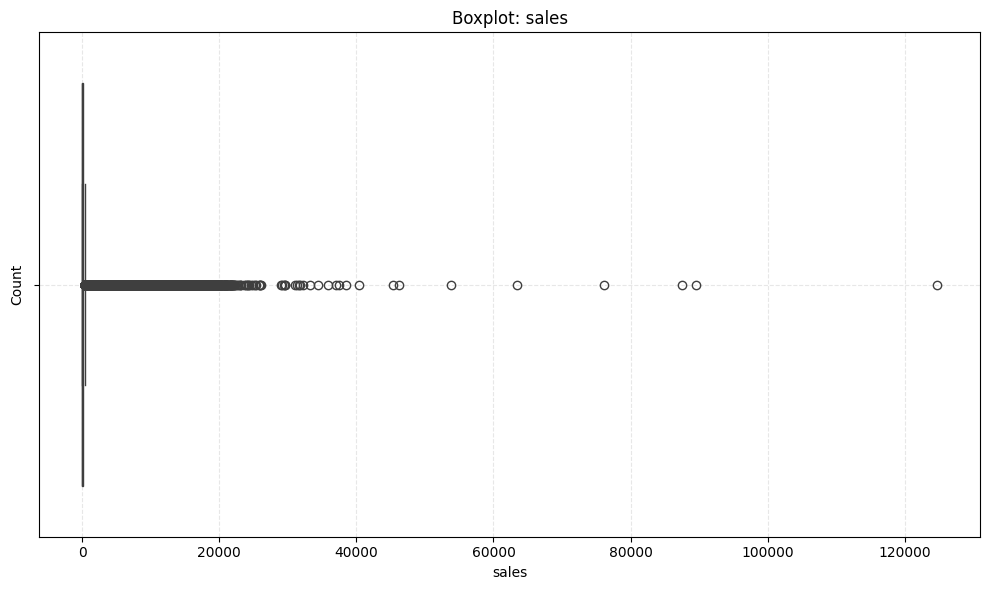

In [ ]:
boxplot(new_train_df, 'sales')

In [ ]:
print(f'sales quantile 75%: {new_train_df['sales'].quantile(0.75)}')
print(f'sales quantile 25%: {new_train_df['sales'].quantile(0.25)}')
print(f'sales median: {new_train_df['sales'].median()}')
print(f'sales quantile 90%: {new_train_df['sales'].quantile(0.90)}')
print(f'sales quantile 99%: {new_train_df['sales'].quantile(0.99)}')

sales quantile 75%: 190.0
sales quantile 25%: 0.0
sales median: 10.0
sales quantile 90%: 846.258
sales quantile 99%: 5398.0



📊 Exploratory Sales Analysis

The distribution of the target variable reveals a heavily skewed retail environment:

1. **Sparsity of Demand:** 25% of the observations in the dataset report zero sales, indicating frequent periods of inactivity for specific product families or stores.
2. **Low-Volume Baseline:** The median sales value is 10 units or less, showing that half of the daily transactions are relatively small-scale.
3. **Heavy-Tailed Distribution:** Sales exhibit an extreme "long tail." While the 75th percentile sits at 190 units, the 90th percentile surges to 840 units—more than a four-fold increase. This gap suggests that a small number of high-performing stores and families drive the vast majority of total volume.


## Time Related Analysis

👉 In this section we will extract time-related features to allow the prediction model to learn time-based context, such as monthly trends, weekly trends and so on.


In [37]:
new_train_df = add_time_features(new_train_df)

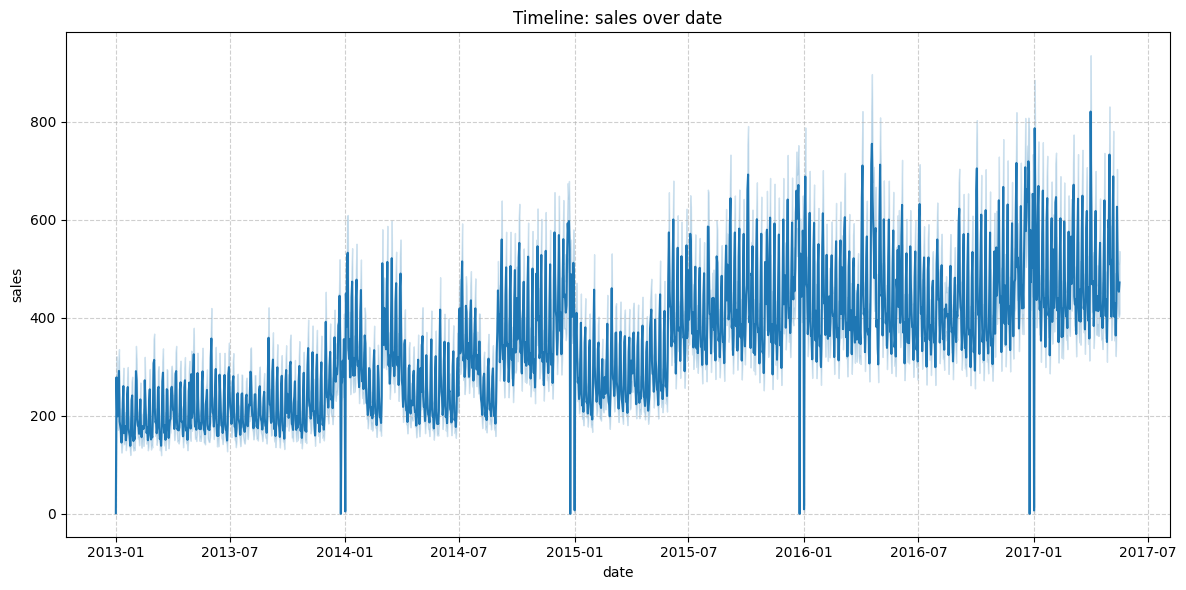

In [ ]:
plot_timeline(new_train_df, 'date', 'sales')

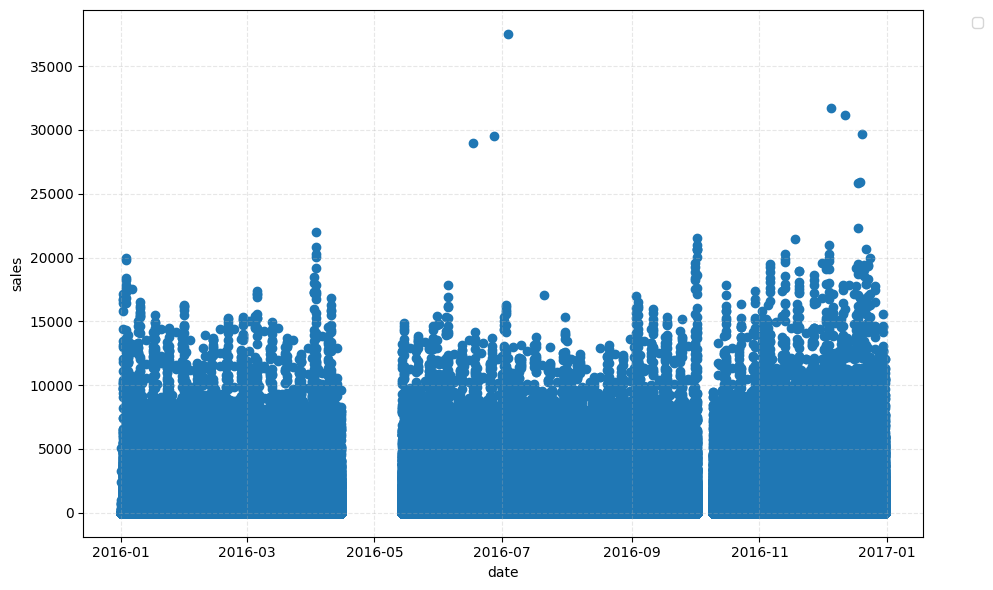

In [81]:
df_2016 = new_train_df[(new_train_df['date'] >= '2016-01-01') & (new_train_df['date'] < '2017-01-01')]
plot_scatter(df_2016, 'date', 'sales')

ADD!!!

In [38]:
new_train_df = new_train_df.drop(new_train_df.loc[new_train_df.date.between('2016-04-16', '2016-05-13')].index)
new_train_df = new_train_df.drop(new_train_df.loc[new_train_df.date.between('2016-10-03', '2016-10-09')].index)

👉 We see in the timeplot above an increasing trend over the years, suggesting an overall increasing yearly trend.

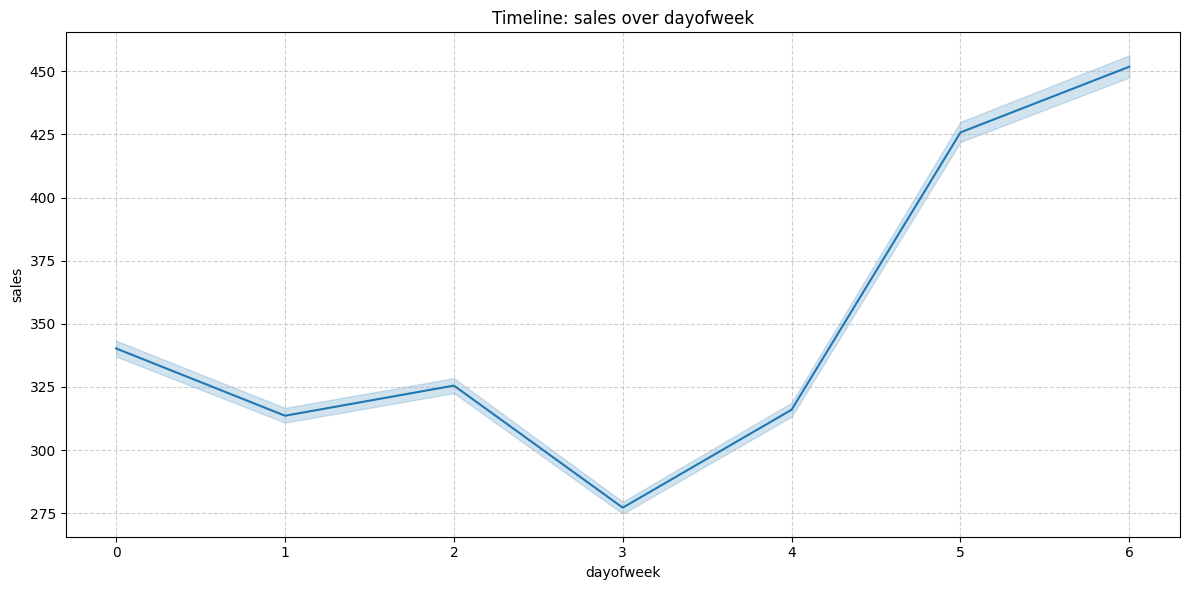

In [ ]:
plot_timeline(new_train_df, 'dayofweek', 'sales')

👉 Weekends associate with higher sales!

## Specific Store Analysis

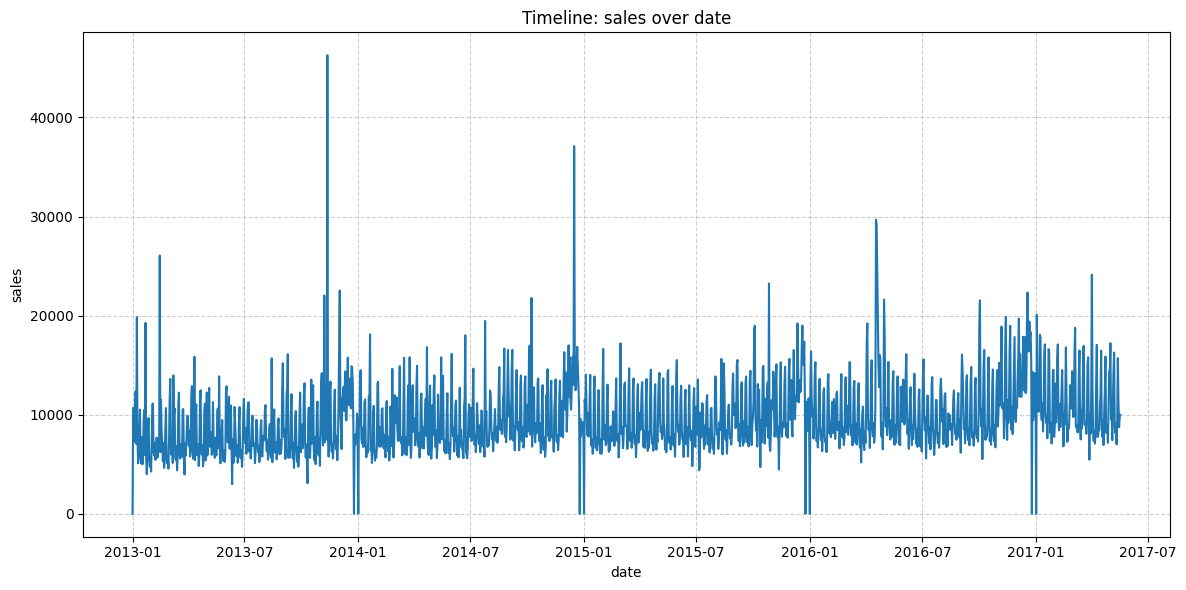

In [ ]:
store_family_df = specific_df(new_train_df, 44, 'GROCERY I')
plot_timeline(store_family_df, 'date', 'sales')

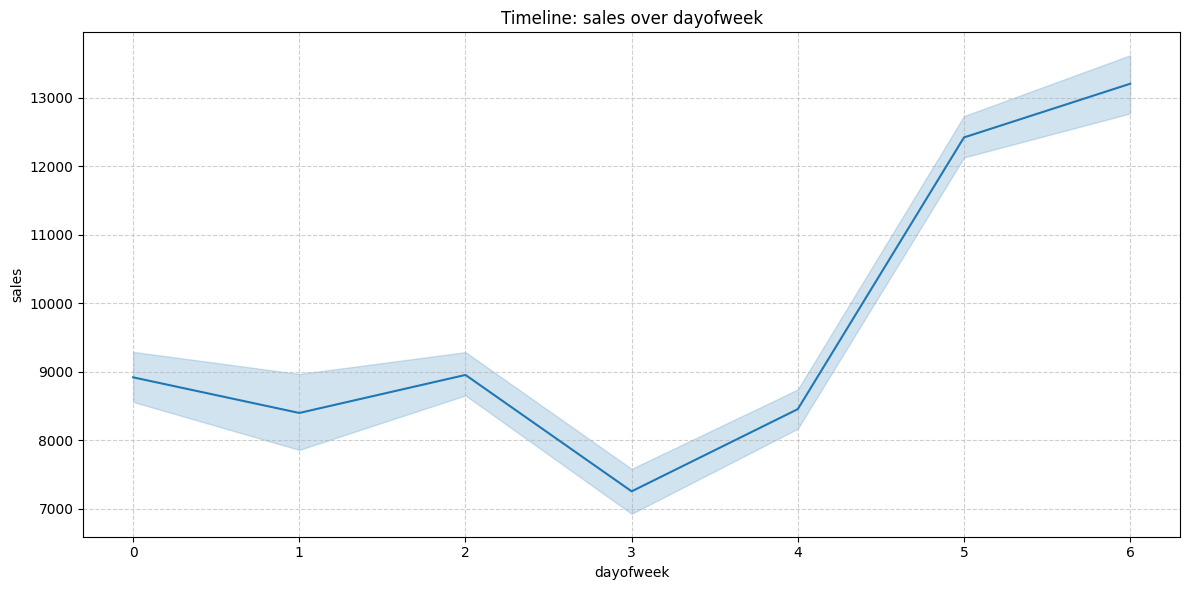

In [ ]:
plot_timeline(store_family_df, 'dayofweek', 'sales')

Running decomposition (Period=365, Model=additive)...


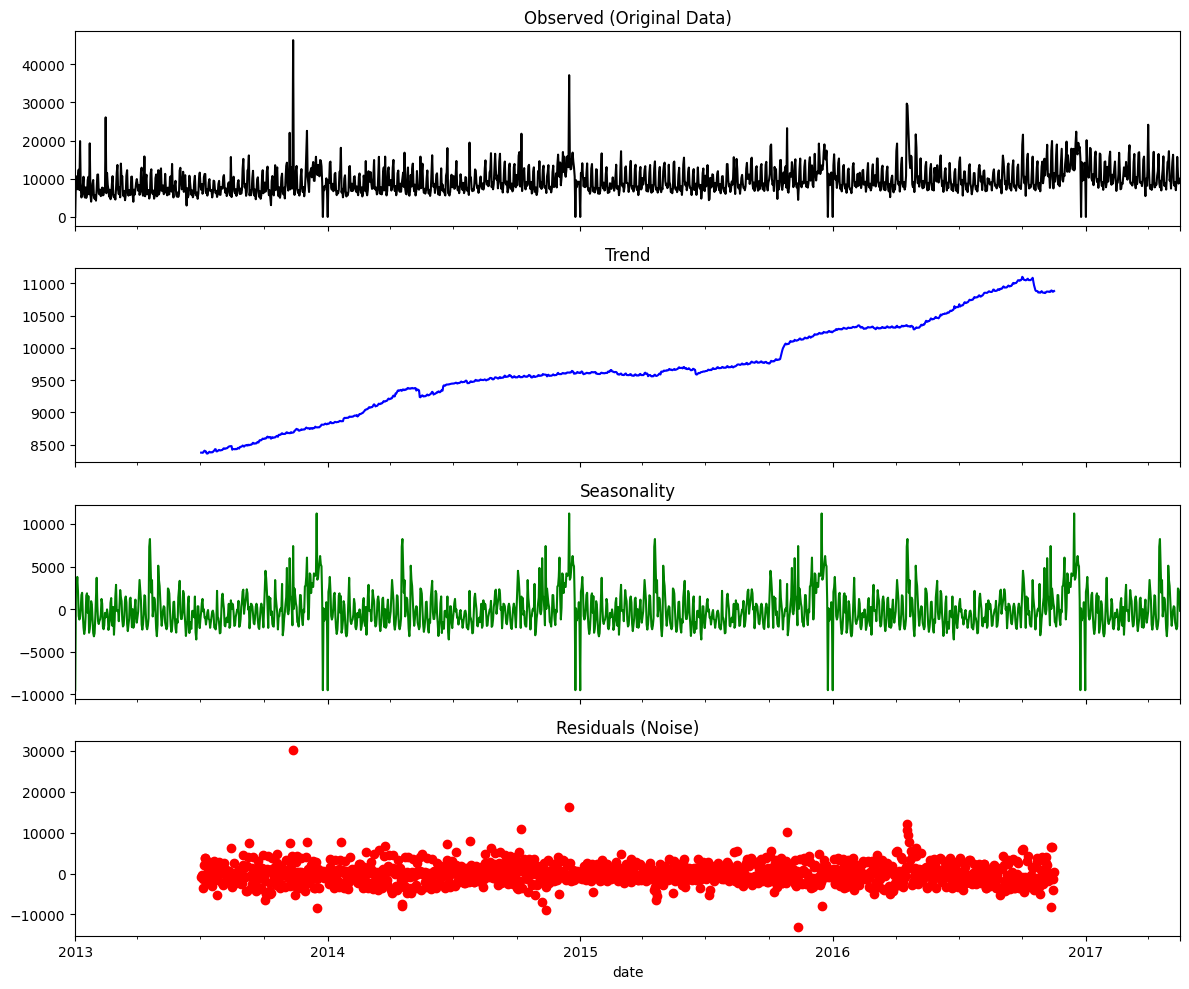

In [ ]:
plot_ts_decomposition(store_family_df, 'date', 'sales', period=365, model='additive')

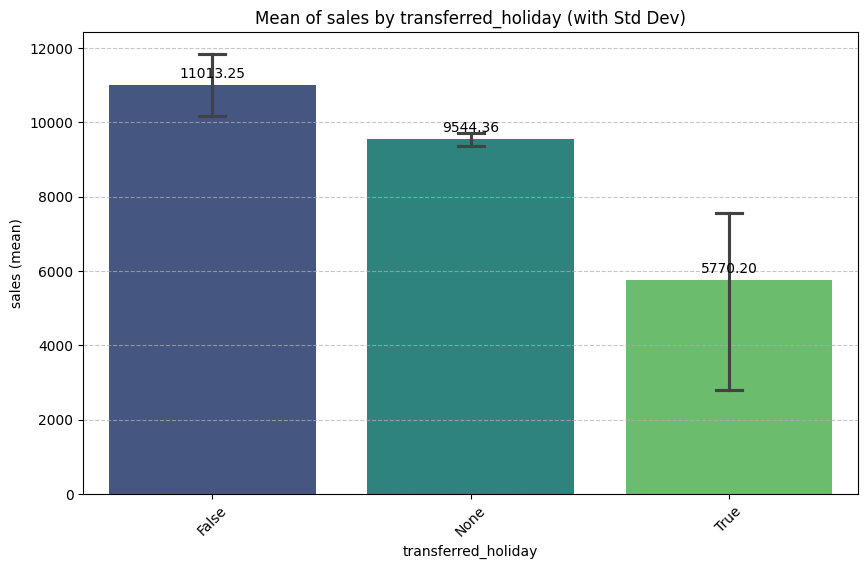

In [ ]:
plot_categorical_bar(store_family_df, 'transferred_holiday', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

## 🔍 Exploratory Data Analysis (EDA) Summary

### 1. Feature Importance & Association

* **Insight:** Most features—specifically `store_nbr`, `family`, and `onpromotion`—show a **strong association** with the target sales value.
* **Impact:** These variables are considered extremely important for the training phase. The model's ability to differentiate between a high-volume "Family" (like Beverages) and a low-volume one is foundational to its accuracy.

### 2. Strategic Exclusion: Oil Prices

* **Decision:** **Oil prices will be ignored** in this implementation.
* **Reasoning:** In a real-world scenario, we cannot assume that future daily oil prices are known in advance. Using them as a feature would create a "look-ahead" bias (data leakage) that doesn't reflect a real-world forecasting environment. To ensure the model is robust and deployable, we rely only on features available at the moment of prediction.

### 3. Temporal Dynamics & Seasonality

* **Insight:** Time-related features demonstrate powerful relationships with sales:
* **Annual Trend:** A clear **yearly increasing trend** is visible, indicating consistent growth in the retailer's operations over time.
* **Weekly Seasonality:** There is a distinct relationship between the **day of the week** and sales volume (e.g., weekend surges or mid-week lulls).


* **Impact:** Capturing these cycles is the primary goal of our engineered features (rolling means and slopes), as they allow the model to adjust for the specific "momentum" of the current week and month.


In [39]:
new_train_df.drop(columns=['dcoilwtico'], inplace=True, errors='ignore')
test_df.drop(columns=['dcoilwtico'], inplace=True, errors='ignore')

# Feature Engineering

The core of our forecasting strategy lies in transforming raw transactional data into meaningful signals that describe **momentum, history, and grouping context**. Since time-series models thrive on understanding past behavior to predict the future, we focus on three distinct levels of aggregation: **Product Family**, **Store**, and the intersection of **Store-Family**.

To prevent **data leakage**, all features are derived from "yesterday's" data (using a 1-day shift), ensuring the model only uses information that would actually be available at the time of a real-world prediction.

---

### 1. Hierarchical Aggregation Levels

We engineer features across three granularities to capture different sales drivers:

* **Family Level:** Captures broad consumer trends for specific product types (e.g., are "Beverages" trending up across the entire country?).
* **Store Level:** Captures the general health and traffic of a specific location (e.g., is Store #1 seeing more customers overall?).
* **Store-Family Level:** Captures highly localized product performance (e.g., how are "Cleaning Supplies" performing specifically at Store #10?).

---

### 2. Engineered Feature Types

For each of the levels above, we calculate the following metrics:

#### 📈 Rolling Averages (Smoothing)

* **7-Day & 30-Day Windows:** These features smooth out daily volatility to reveal the underlying short-term and long-term trends. They help the model distinguish between a random daily spike and a sustained increase in demand.

#### 🕒 Lagged Features (Seasonality)

* **Week-Ago & Month-Ago Lags:** By looking exactly 7 and 30 days back, we provide the model with a direct reference to weekly and monthly cycles. This is critical for capturing "same-day-last-week" effects.

#### 🚀 Velocity & Acceleration (Slopes)

* **Weekly & Monthly Slopes:** We calculate the rate of change (linear slope) over the last 7 and 30 days. This tells the model not just where sales *are*, but how fast they are *growing or shrinking*.
* **Weekly Change (Ratio):** A relative measure of growth that helps identify percentage-based shifts in consumer behavior.

---

### 3. Recursive Readiness

These features are designed for a **recursive forecasting loop**. By using `shift(1)`, we ensure that as we predict Day 1 of the test set, we can append that prediction to our history and immediately recalculate these features for Day 2, allowing the model to project trends 15 days into the future.

**Next Step:** With our features defined, we will move to **Z-score scaling** to normalize these slopes and averages, ensuring our Ridge and XGBoost models interpret the magnitudes correctly.

In [40]:
# rolling mean of sales per family
rolling_mean_df = new_train_df.groupby(['date', 'family'])['sales'].mean().reset_index()
rolling_mean_df['sales_last_day_family'] = rolling_mean_df.groupby('family')['sales'].transform(lambda x: x.shift(1))
rolling_mean_df.drop(columns=['sales'], inplace=True)
rolling_mean_df['rolling_mean_family_7'] = rolling_mean_df.groupby('family')['sales_last_day_family'].transform(lambda x: x.rolling(7).mean())
rolling_mean_df['rolling_mean_family_30'] = rolling_mean_df.groupby('family')['sales_last_day_family'].transform(lambda x: x.rolling(30).mean())
rolling_mean_df['sales_week_ago_family'] = rolling_mean_df.groupby('family')['sales_last_day_family'].transform(lambda x: x.shift(7))
rolling_mean_df['sales_month_ago_family'] = rolling_mean_df.groupby('family')['sales_last_day_family'].transform(lambda x: x.shift(30))
rolling_mean_df['weekly_change_family'] = rolling_mean_df['sales_last_day_family'] / rolling_mean_df['sales_week_ago_family']
rolling_mean_df['weekly_slope_family'] = (rolling_mean_df['sales_last_day_family'] - rolling_mean_df['sales_week_ago_family']) / 7
rolling_mean_df['monthly_slope_family'] = (rolling_mean_df['sales_last_day_family'] - rolling_mean_df['sales_month_ago_family']) / 30

# rolling mean of sales per family & store
rolling_mean_store_family_df = new_train_df.groupby(['date', 'store_nbr', 'family'])['sales'].mean().reset_index()
rolling_mean_store_family_df['sales_last_day_store_family'] = rolling_mean_store_family_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1))
rolling_mean_store_family_df.drop(columns=['sales'], inplace=True)
rolling_mean_store_family_df['rolling_mean_store_family_7'] = rolling_mean_store_family_df.groupby(['store_nbr', 'family'])['sales_last_day_store_family'].transform(lambda x: x.rolling(7).mean())
rolling_mean_store_family_df['rolling_mean_store_family_30'] = rolling_mean_store_family_df.groupby(['store_nbr', 'family'])['sales_last_day_store_family'].transform(lambda x: x.rolling(30).mean())
rolling_mean_store_family_df['sales_week_ago_store_family'] = rolling_mean_store_family_df.groupby(['store_nbr', 'family'])['sales_last_day_store_family'].transform(lambda x: x.shift(7))
rolling_mean_store_family_df['sales_month_ago_store_family'] = rolling_mean_store_family_df.groupby(['store_nbr', 'family'])['sales_last_day_store_family'].transform(lambda x: x.shift(30))
rolling_mean_store_family_df['weekly_change_store_family'] = rolling_mean_store_family_df['sales_last_day_store_family'] / rolling_mean_store_family_df['sales_week_ago_store_family']
rolling_mean_store_family_df['weekly_slope_store_family'] = (rolling_mean_store_family_df['sales_last_day_store_family'] - rolling_mean_store_family_df['sales_week_ago_store_family']) / 7
rolling_mean_store_family_df['monthly_slope_store_family'] = (rolling_mean_store_family_df['sales_last_day_store_family'] - rolling_mean_store_family_df['sales_month_ago_store_family']) / 30

# rolling mean of sales per store
rolling_mean_store_df = new_train_df.groupby(['date', 'store_nbr'])['sales'].mean().reset_index()
rolling_mean_store_df['sales_last_day_store'] = rolling_mean_store_df.groupby('store_nbr')['sales'].transform(lambda x: x.shift(1))
rolling_mean_store_df.drop(columns=['sales'], inplace=True)
rolling_mean_store_df['rolling_mean_store_7'] = rolling_mean_store_df.groupby('store_nbr')['sales_last_day_store'].transform(lambda x: x.rolling(7).mean())
rolling_mean_store_df['rolling_mean_store_30'] = rolling_mean_store_df.groupby('store_nbr')['sales_last_day_store'].transform(lambda x: x.rolling(30).mean())
rolling_mean_store_df['sales_week_ago_store'] = rolling_mean_store_df.groupby('store_nbr')['sales_last_day_store'].transform(lambda x: x.shift(7))
rolling_mean_store_df['sales_month_ago_store'] = rolling_mean_store_df.groupby('store_nbr')['sales_last_day_store'].transform(lambda x: x.shift(30))
rolling_mean_store_df['weekly_change_store'] = rolling_mean_store_df['sales_last_day_store'] / rolling_mean_store_df['sales_week_ago_store']
rolling_mean_store_df['weekly_slope_store'] = (rolling_mean_store_df['sales_last_day_store'] - rolling_mean_store_df['sales_week_ago_store']) / 7
rolling_mean_store_df['monthly_slope_store'] = (rolling_mean_store_df['sales_last_day_store'] - rolling_mean_store_df['sales_month_ago_store']) / 30


In [41]:
# merge dfs
new_train_df_w_time = new_train_df.merge(rolling_mean_df, how='left', on=['date', 'family'])
new_train_df_w_time = new_train_df_w_time.merge(rolling_mean_store_family_df, how='left', on=['date', 'store_nbr', 'family'])
new_train_df_w_time = new_train_df_w_time.merge(rolling_mean_store_df, how='left', on=['date', 'store_nbr'])

#1st of january
new_train_df_w_time['is_first_january'] = new_train_df_w_time['date'].dt.day == 1


# Correlation MX

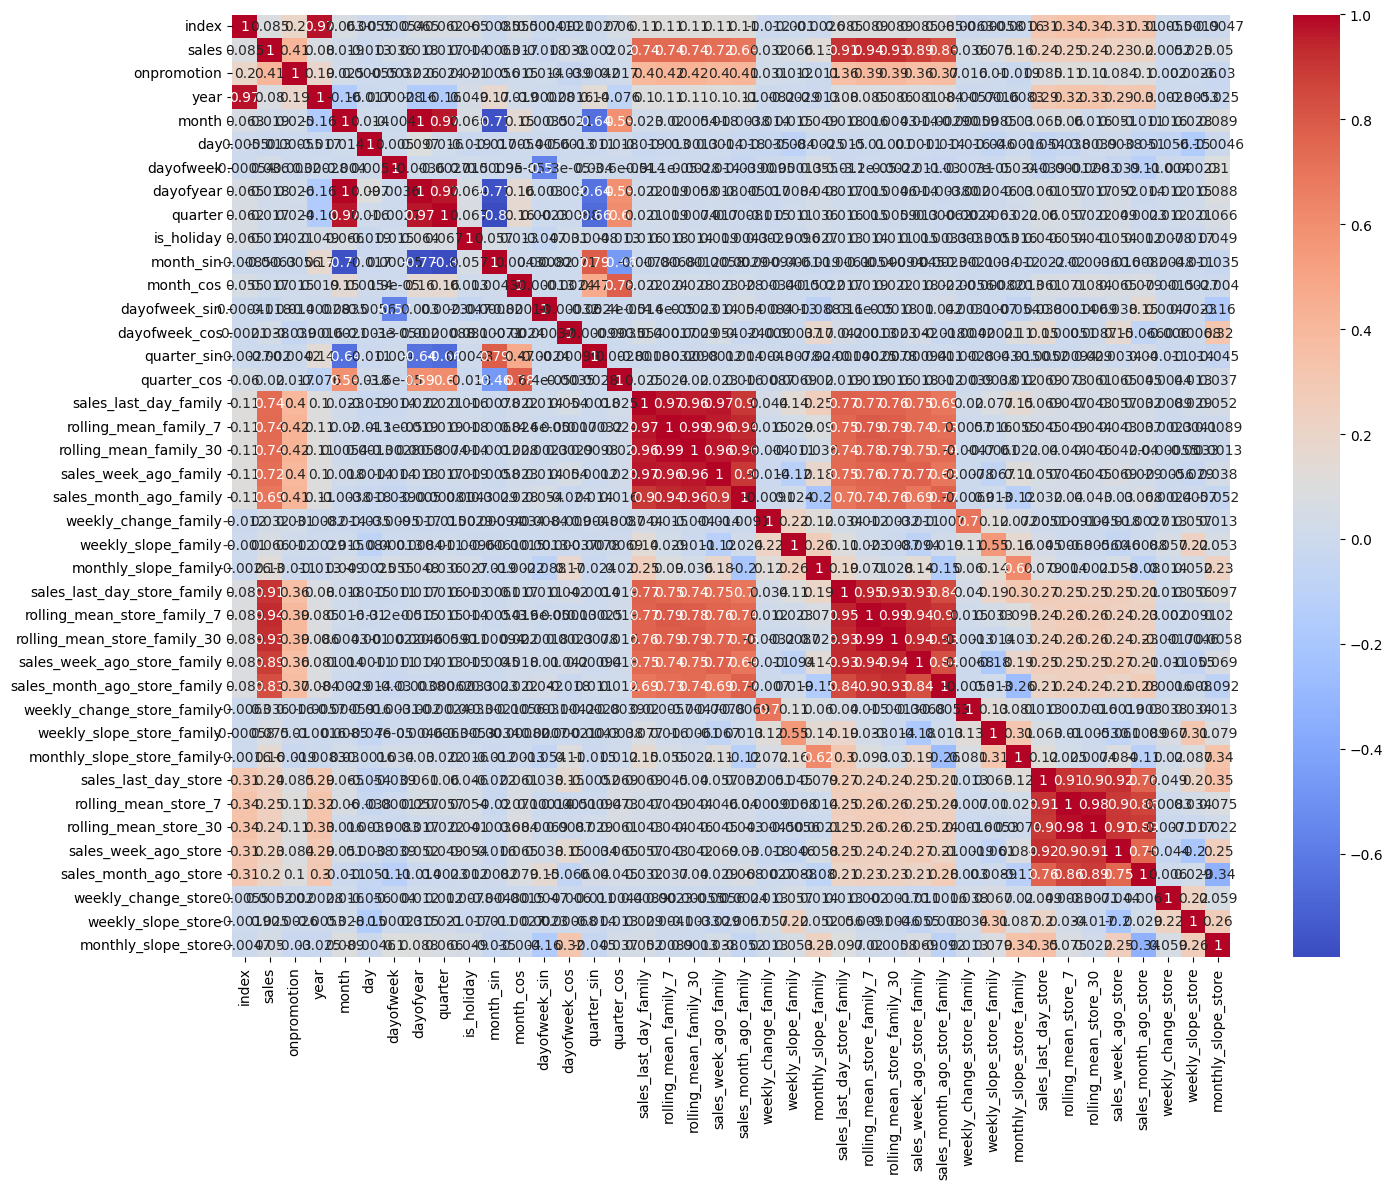

In [ ]:
numerical_cols = [x for x in new_train_df_w_time.describe().columns if x not in ['id', 'date', 'store_nbr', 'cluster_store']] 
# new_train_df_w_time[numerical_cols].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(new_train_df_w_time[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

In [ ]:
new_train_df_w_time[numerical_cols].corr()['sales'].sort_values(ascending=False)

sales                           1.000000
rolling_mean_store_family_7     0.935477
rolling_mean_store_family_30    0.927448
sales_last_day_store_family     0.912858
sales_week_ago_store_family     0.887618
sales_month_ago_store_family    0.834289
rolling_mean_family_7           0.744452
rolling_mean_family_30          0.739520
sales_last_day_family           0.739380
sales_week_ago_family           0.724185
sales_month_ago_family          0.691374
onpromotion                     0.411406
rolling_mean_store_7            0.246410
rolling_mean_store_30           0.243744
sales_last_day_store            0.238331
sales_week_ago_store            0.228504
sales_month_ago_store           0.204871
monthly_slope_store_family      0.157034
monthly_slope_family            0.127404
index                           0.085140
year                            0.080098
weekly_slope_store_family       0.074628
weekly_slope_family             0.065817
monthly_slope_store             0.050041
dayofweek_cos   

## EDA with latest new features

This analysis focus on the time-relates sales features that were engineered above.

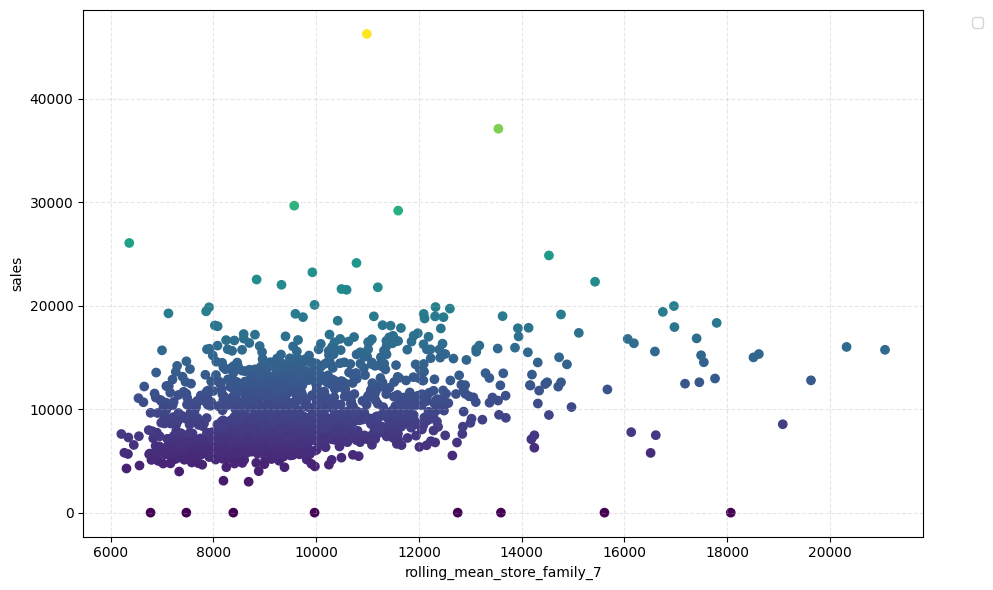

In [ ]:
new_specific = specific_df(new_train_df_w_time, 44, 'GROCERY I')
plot_scatter(new_specific, 'rolling_mean_store_family_7', 'sales', 'sales')

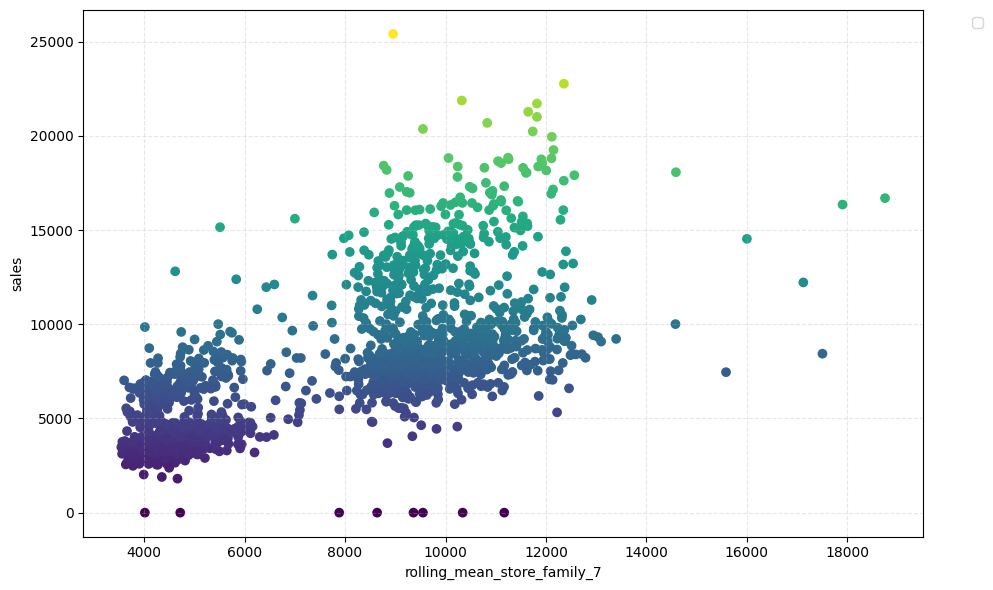

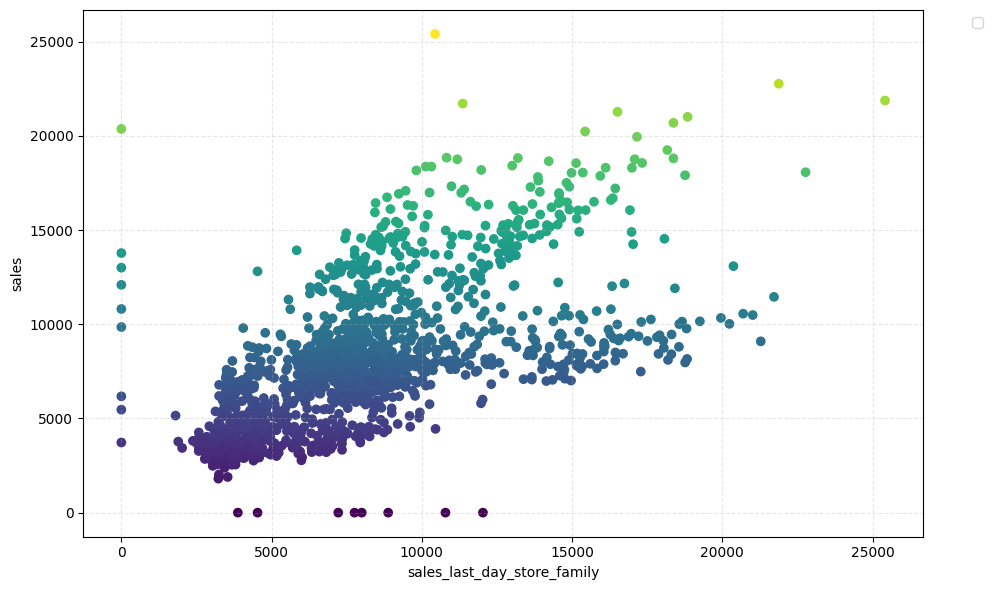

In [ ]:
new_specific = specific_df(new_train_df_w_time, 44, 'BEVERAGES')
plot_scatter(new_specific, 'rolling_mean_store_family_7', 'sales', 'sales')
plot_scatter(new_specific, 'sales_last_day_store_family', 'sales', 'sales')

## ⏳ Time-Series Feature Analysis Summary

👉 Strong Predictive Power of Historical Features Both correlation analysis and visual inspection confirm that engineered historical features are the strongest predictors of future sales. For instance, the rolling_mean_store_family_7 feature (representing average sales for a specific product family at a specific store over the prior week) shows a correlation of 0.935, indicating an almost perfect positive linear relationship with the target. This high coefficient suggests that recent local history is the primary driver of future performance.

👉 Multicollinearity and Group Dynamics The correlation matrix reveals high internal correlation (multicollinearity) between features within the same aggregation groups (e.g., a 7-day rolling mean is highly correlated with a 30-day rolling mean). This suggests that while all these features are strong individually, the model may benefit from dimensionality reduction or regularization (like Ridge) to prevent redundant information from inflating the importance of specific time windows. Feature selection should focus on identifying the most unique signals from each group (Family vs. Store vs. Family-Store) rather than treating all lags as independent variables.

# Evaluate Models


In [34]:
target_col = 'sales'
numerical_cols = [x for x in new_train_df_w_time.describe().columns if x not in ['id', 'date', 'store_nbr', 'cluster_store']] 
numerical_features = [x for x in numerical_cols if x not in ['sales', 'is_holiday', 'is_first_january', 'index']]
categorical_features = [x for x in new_train_df_w_time.columns if x not in (numerical_features + ['id', 'date', 'sales', 'index'])]

## 🛠️ Final Preprocessing, Training, and Evaluation

To streamline the workflow, we utilize two core functions (located in the `utils.py` file) that handle the end-to-end pipeline from raw feature data to recursive forecasting.

#### 1. `prepare_and_fit_train`

This function executes the final data preparation and initial model training. It receives the model architecture, the training data, and the specific feature lists (categorical and numerical).

* **Final Preprocessing Pipeline:**
* **Feature Scaling:** To ensure numerical stability, **Min-Max scaling** is applied to features with finite, defined ranges, while **Z-score normalization** (`StandardScaler`) is applied to unbounded numerical features.
* **Categorical Encoding:** We utilize **One-Hot Encoding** (via `get_dummies`) to convert categorical variables into a format compatible with our models. This is particularly critical for **Linear Regression with Ridge regularization**, which is highly sensitive to feature magnitude and requires numerical input matrices.
* **Log Transformation:** To directly optimize for the **RMSLE** evaluation metric, we transform the target variable using  before fitting the model. This serves two critical purposes: (1) **Metric Alignment:** It converts the model’s objective from minimizing absolute differences (MSE) to minimizing **relative ratios**, ensuring that a 10% error on a small store is penalized equally to a 10% error on a large store. (2) **Variance Stabilization:** It compresses the range of the target variable, reducing the impact of high-volume outliers and producing a more normal distribution that is easier for gradient-based models like XGBoost to learn.


* **Domain-Specific Corrections:** After training, the function applies a rule-based correction based on observed historical trends: sales on **January 1st** and **December 25th (Christmas Day)** are automatically set to **0**, reflecting typical store closures.
* **Outputs:** The function returns the fully trained model and the fitted scalers required for the testing phase.

---

#### 2. `predict_test`

This function manages the **Recursive Forecasting Pipeline**. It receives the trained model, the fitted scalers, and the test data to project sales over the 15-day test window.

* **Recursive Logic:** Since our engineered features rely on historical lags (e.g., "yesterday's sales"), the function predicts one day at a time. Once a day is predicted, that value is treated as the "ground truth" to update the history.
* **Dynamic Feature Re-computation:** For each subsequent date in the test set, the function re-calculates the past sales features (rolling means, slopes, and lags) using the combined set of known history and previously generated predictions.
* **Outputs:** The function produces the final prediction dataframe for the entire test period.


## 📉 Evaluating Models: XGBoost & Linear Regression

With the data fully prepared, we move to the evaluation of two distinct modeling architectures:

👉 **Linear Regression:** Serving as our traditional baseline, this model is designed to capture the fundamental linear relationships between our engineered features and the target sales. 

👉 **XGBoost:** As a gradient-boosted decision tree framework, XGBoost is capable of capturing complex, non-linear interactions that a linear model might miss. It is widely recognized for its robustness and state-of-the-art performance in tabular time-series forecasting tasks.

We will utilize **RMSE (Root Mean Squared Error)** as our primary evaluation metric. This metric is particularly useful here as it penalizes larger errors more heavily, ensuring our forecast remains reliable. The results of this comparison will determine which model we select for the subsequent **fine-tuning stage**, where we will perform advanced feature selection and hyper-parameter optimization.


In [35]:
lr_model = LinearRegression()
xgb_model = XGBRegressor(n_estimators=80, learning_rate=0.1, n_jobs=-1, random_state=42, reg_lambda=100, enable_categorical=True)

### Preprocess test data features

We now preprocess the test data for time-based only features (month, day, dayofweek...)

In [42]:
test_df = add_time_features(test_df)

### 📈 Linear Regression Evaluation

In [44]:
lr_model, minmax_scaler, z_scaler, X_cols = prepare_and_fit_train(lr_model, new_train_df_w_time, categorical_features, numerical_features, rmsle_metric=True)
lr_results = predict_test(lr_model, minmax_scaler, z_scaler, test_df, new_train_df_w_time, X_cols, categorical_features, numerical_features, rmsle_metric=True)

(2917134, 191)
Train RMSLE: 1.1384831154924118
Train RMSE: 764771068.7630526
Train MAE: 974324.7432996203


Predicting test set: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it]

Test RMSLE: 0.9731156068019335
Test RMSE: 35014.74551805048
Test MAE: 2670.9781447486757


### 🌳🚀 XGBoost Evaluation

In [43]:
xgb_model, minmax_scaler, z_scaler, X_cols = prepare_and_fit_train(xgb_model, new_train_df_w_time, categorical_features, numerical_features, rmsle_metric=True)
xgb_results = predict_test(xgb_model, minmax_scaler, z_scaler, test_df, new_train_df_w_time, X_cols, categorical_features, numerical_features, rmsle_metric=True)

Train RMSLE: 0.40473660366181174
Train RMSE: 244.14386982835853
Train MAE: 55.05344739498909


Predicting test set: 100%|██████████| 16/16 [00:36<00:00,  2.29s/it]

Test RMSLE: 0.404028945566088
Test RMSE: 240.97980580527462
Test MAE: 74.34483173319889


In this stage, we refine our input space by leveraging the **Feature Importance** rankings from our trained XGBoost model.
Out of the 191 total features (largely resulting from the one-hot encoding of categorical variables), we will evaluate performance on subsets of the top  features, where . We will select the feature set that yields the lowest **RMSLE**.

> **Note:** While more rigorous selection methods like Recursive Feature Elimination (RFE) exist, we will maintain this simplified top-k approach for the scope of this notebook.

In [46]:
feature_importance_df = pd.DataFrame({'feature': xgb_model.feature_names_in_, 'importance': xgb_model.feature_importances_})
feature_importance_df.sort_values(by='importance', ascending=False).head(10)

,feature,importance
22,rolling_mean_store_family_7,0.802157
21,sales_last_day_store_family,0.107779
2,month,0.012168
24,sales_week_ago_store_family,0.006553
180,type_holiday_Holiday,0.005036
107,family_HOME CARE,0.005018
5,dayofyear,0.004597
4,dayofweek,0.004093
23,rolling_mean_store_family_30,0.003702
111,"family_LIQUOR,WINE,BEER",0.003502


In [375]:
for k in [120, 100, 80, 60, 40]:
    print(f'--- Top {k} Features ---')
    selected_features = feature_importance_df.sort_values(by='importance', ascending=False).head(k)['feature'].tolist()
    xgb_model_temp = XGBRegressor(n_estimators=80, learning_rate=0.1, n_jobs=-1, random_state=42, reg_lambda=100)
    xgb_model_temp, minmax_scaler, z_scaler, X_cols = prepare_and_fit_train(xgb_model_temp, new_train_df_w_time, categorical_features, numerical_features, feature_selection=selected_features)
    xgb_results_temp = predict_test(xgb_model_temp, minmax_scaler, z_scaler, test_df, new_train_df_w_time, X_cols, categorical_features, numerical_features, feature_selection=selected_features)

--- Top 120 Features ---
(2917134, 120)
Train RMSLE: 0.40473672025959956
Train RMSE: 244.1678758520745
Train MAE: 55.05481681206408


Predicting test set: 100%|██████████| 16/16 [00:28<00:00,  1.80s/it]


Test RMSLE: 0.4040271470116629
Test RMSE: 240.94282088255844
Test MAE: 74.34113969814955
--- Top 100 Features ---
(2917134, 100)
Train RMSLE: 0.4046938986403765
Train RMSE: 245.04855493296407
Train MAE: 55.17317350049712


Predicting test set: 100%|██████████| 16/16 [00:28<00:00,  1.80s/it]


Test RMSLE: 0.4048786943221341
Test RMSE: 246.97500244347808
Test MAE: 76.18890591576891
--- Top 80 Features ---
(2917134, 80)
Train RMSLE: 0.4043006599119178
Train RMSE: 242.97906275269392
Train MAE: 54.934018041881515


Predicting test set: 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


Test RMSLE: 0.40453039053480505
Test RMSE: 266.6576978976412
Test MAE: 78.22882923149753
--- Top 60 Features ---
(2917134, 60)
Train RMSLE: 0.40557535557042446
Train RMSE: 243.89869394633087
Train MAE: 55.08378981532801


Predicting test set: 100%|██████████| 16/16 [00:29<00:00,  1.86s/it]


Test RMSLE: 0.40543891729382453
Test RMSE: 255.59184168590454
Test MAE: 76.57095653036733
--- Top 40 Features ---
(2917134, 40)
Train RMSLE: 0.4053016575758147
Train RMSE: 243.50478902104456
Train MAE: 55.5874667241


Predicting test set: 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]

Test RMSLE: 0.40731195921091434
Test RMSE: 264.7308116751618
Test MAE: 78.9884283798986


According to the iterations above, we fount that top 120 features had a slight decrease in both RMSLE of the test subsets. Therefore, we shall continue with the top 120 features as the selected subset of features.

In [47]:
final_features_set = feature_importance_df.sort_values(by='importance', ascending=False).head(120)['feature'].tolist()

# ⚙️ Hyper-parameter Optimization

We proceed with a focused hyper-parameter tuning phase to evaluate different configurations for the XGBoost architecture. The objective is to find a balance between model complexity and generalization.

> **Note:** This process uses a targeted search space rather than an exhaustive Grid Search to keep the computation efficient for this analysis.

In [49]:
# n_estimators = [80, 200, 300]
n_estimators = [300]
learning_rate = [0.05, 0.08, 0.1]
subsample = [0.8, 1]
max_depth = [5, 7, 9, 11]

for n in n_estimators:
    for l in learning_rate:
        for s in subsample:
            for m in max_depth:
                print(f'--- n_estimators={n}, learning_rate={l}, sub_sumple={s}, max_depth={m} ---')
                xgb_model_temp = XGBRegressor(n_estimators=n, learning_rate=l, n_jobs=-1, random_state=42, sub_sumple=s, max_depth=m, reg_lambda=50)
                xgb_model_temp, minmax_scaler, z_scaler, X_cols = prepare_and_fit_train(xgb_model_temp, new_train_df_w_time, categorical_features, numerical_features, feature_selection=final_features_set)
                xgb_results_temp = predict_test(xgb_model_temp, minmax_scaler, z_scaler, test_df, new_train_df_w_time, X_cols, categorical_features, numerical_features, feature_selection=final_features_set)

--- n_estimators=300, learning_rate=0.05, sub_sumple=0.8, max_depth=5 ---
Train RMSLE: 0.4035473147160275
Train RMSE: 233.8926468395398
Train MAE: 53.251085749239714


Predicting test set: 100%|██████████| 16/16 [00:35<00:00,  2.21s/it]


Test RMSLE: 0.4100399743550976
Test RMSE: 287.76652069042785
Test MAE: 89.73687679099672
--- n_estimators=300, learning_rate=0.05, sub_sumple=0.8, max_depth=7 ---
Train RMSLE: 0.37930287723322464
Train RMSE: 209.83056411560983
Train MAE: 47.54951777220033


Predicting test set: 100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


Test RMSLE: 0.3926898335761615
Test RMSE: 240.1589406722652
Test MAE: 71.58220262460488
--- n_estimators=300, learning_rate=0.05, sub_sumple=0.8, max_depth=9 ---
Train RMSLE: 0.36069546083510623
Train RMSE: 192.50433195040287
Train MAE: 42.446482836101474


Predicting test set: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


Test RMSLE: 0.38563117143004094
Test RMSE: 245.82959727533034
Test MAE: 70.21109547585752
--- n_estimators=300, learning_rate=0.05, sub_sumple=0.8, max_depth=11 ---
Train RMSLE: 0.34473897378294677
Train RMSE: 178.60425789746824
Train MAE: 38.78522729154868


Predicting test set: 100%|██████████| 16/16 [01:08<00:00,  4.30s/it]


Test RMSLE: 0.3832237773614424
Test RMSE: 242.42236086579356
Test MAE: 69.23294279653246
--- n_estimators=300, learning_rate=0.05, sub_sumple=1, max_depth=5 ---
Train RMSLE: 0.4035473147160275
Train RMSE: 233.8926468395398
Train MAE: 53.251085749239714


Predicting test set: 100%|██████████| 16/16 [00:53<00:00,  3.34s/it]


Test RMSLE: 0.4100399743550976
Test RMSE: 287.76652069042785
Test MAE: 89.73687679099672
--- n_estimators=300, learning_rate=0.05, sub_sumple=1, max_depth=7 ---
Train RMSLE: 0.37930287723322464
Train RMSE: 209.83056411560983
Train MAE: 47.54951777220033


Predicting test set: 100%|██████████| 16/16 [01:05<00:00,  4.07s/it]


Test RMSLE: 0.3926898335761615
Test RMSE: 240.1589406722652
Test MAE: 71.58220262460488
--- n_estimators=300, learning_rate=0.05, sub_sumple=1, max_depth=9 ---
Train RMSLE: 0.36069546083510623
Train RMSE: 192.50433195040287
Train MAE: 42.446482836101474


Predicting test set: 100%|██████████| 16/16 [00:51<00:00,  3.19s/it]


Test RMSLE: 0.38563117143004094
Test RMSE: 245.82959727533034
Test MAE: 70.21109547585752
--- n_estimators=300, learning_rate=0.05, sub_sumple=1, max_depth=11 ---
Train RMSLE: 0.34473897378294677
Train RMSE: 178.60425789746824
Train MAE: 38.78522729154868


Predicting test set: 100%|██████████| 16/16 [00:49<00:00,  3.09s/it]


Test RMSLE: 0.3832237773614424
Test RMSE: 242.42236086579356
Test MAE: 69.23294279653246
--- n_estimators=300, learning_rate=0.08, sub_sumple=0.8, max_depth=5 ---
Train RMSLE: 0.39404720949112226
Train RMSE: 224.72271059192056
Train MAE: 50.6948511789738


Predicting test set: 100%|██████████| 16/16 [01:08<00:00,  4.31s/it]


Test RMSLE: 0.40639593352359205
Test RMSE: 318.20025488032763
Test MAE: 95.70761233611896
--- n_estimators=300, learning_rate=0.08, sub_sumple=0.8, max_depth=7 ---
Train RMSLE: 0.36957410746500435
Train RMSE: 199.14780799273882
Train MAE: 44.717037098838375


Predicting test set: 100%|██████████| 16/16 [00:51<00:00,  3.22s/it]


Test RMSLE: 0.38861948664893364
Test RMSE: 239.1319160338313
Test MAE: 69.67956295335404
--- n_estimators=300, learning_rate=0.08, sub_sumple=0.8, max_depth=9 ---
Train RMSLE: 0.35200943575946464
Train RMSE: 180.6088833695956
Train MAE: 39.73232421185706


Predicting test set: 100%|██████████| 16/16 [00:50<00:00,  3.13s/it]


Test RMSLE: 0.38182285711551606
Test RMSE: 232.55117236671308
Test MAE: 66.43901937829963
--- n_estimators=300, learning_rate=0.08, sub_sumple=0.8, max_depth=11 ---
Train RMSLE: 0.3329672669348948
Train RMSE: 167.13057169819638
Train MAE: 36.07917396913136


Predicting test set: 100%|██████████| 16/16 [00:53<00:00,  3.35s/it]


Test RMSLE: 0.3807121920383085
Test RMSE: 242.25613741487618
Test MAE: 68.54266393846905
--- n_estimators=300, learning_rate=0.08, sub_sumple=1, max_depth=5 ---
Train RMSLE: 0.39404720949112226
Train RMSE: 224.72271059192056
Train MAE: 50.6948511789738


Predicting test set: 100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Test RMSLE: 0.40639593352359205
Test RMSE: 318.20025488032763
Test MAE: 95.70761233611896
--- n_estimators=300, learning_rate=0.08, sub_sumple=1, max_depth=7 ---
Train RMSLE: 0.36957410746500435
Train RMSE: 199.14780799273882
Train MAE: 44.717037098838375


Predicting test set: 100%|██████████| 16/16 [00:53<00:00,  3.32s/it]


Test RMSLE: 0.38861948664893364
Test RMSE: 239.1319160338313
Test MAE: 69.67956295335404
--- n_estimators=300, learning_rate=0.08, sub_sumple=1, max_depth=9 ---
Train RMSLE: 0.35200943575946464
Train RMSE: 180.6088833695956
Train MAE: 39.73232421185706


Predicting test set: 100%|██████████| 16/16 [00:35<00:00,  2.23s/it]


Test RMSLE: 0.38182285711551606
Test RMSE: 232.55117236671308
Test MAE: 66.43901937829963
--- n_estimators=300, learning_rate=0.08, sub_sumple=1, max_depth=11 ---
Train RMSLE: 0.3329672669348948
Train RMSE: 167.13057169819638
Train MAE: 36.07917396913136


Predicting test set: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Test RMSLE: 0.3807121920383085
Test RMSE: 242.25613741487618
Test MAE: 68.54266393846905
--- n_estimators=300, learning_rate=0.1, sub_sumple=0.8, max_depth=5 ---
Train RMSLE: 0.38944609254159973
Train RMSE: 228.40248188725556
Train MAE: 50.38545927484368


Predicting test set: 100%|██████████| 16/16 [00:36<00:00,  2.25s/it]


Test RMSLE: 0.40192527046925985
Test RMSE: 313.5443333255205
Test MAE: 90.59237392736875
--- n_estimators=300, learning_rate=0.1, sub_sumple=0.8, max_depth=7 ---
Train RMSLE: 0.3652965306383721
Train RMSE: 195.2831028382591
Train MAE: 43.576343565473756


Predicting test set: 100%|██████████| 16/16 [00:37<00:00,  2.31s/it]


Test RMSLE: 0.3880084827192396
Test RMSE: 233.72315376463814
Test MAE: 67.72152720019491
--- n_estimators=300, learning_rate=0.1, sub_sumple=0.8, max_depth=9 ---
Train RMSLE: 0.34754486261721634
Train RMSE: 176.61099179902058
Train MAE: 38.79583175989507


Predicting test set: 100%|██████████| 16/16 [00:35<00:00,  2.20s/it]


Test RMSLE: 0.38345550940681083
Test RMSE: 235.39376462674116
Test MAE: 68.4004897669712
--- n_estimators=300, learning_rate=0.1, sub_sumple=0.8, max_depth=11 ---
Train RMSLE: 0.32844879543199684
Train RMSE: 163.56319712949428
Train MAE: 35.1624547502718


Predicting test set: 100%|██████████| 16/16 [00:35<00:00,  2.20s/it]


Test RMSLE: 0.3809706292571368
Test RMSE: 234.03259109868807
Test MAE: 66.04354071562132
--- n_estimators=300, learning_rate=0.1, sub_sumple=1, max_depth=5 ---
Train RMSLE: 0.38944609254159973
Train RMSE: 228.40248188725556
Train MAE: 50.38545927484368


Predicting test set: 100%|██████████| 16/16 [00:34<00:00,  2.15s/it]


Test RMSLE: 0.40192527046925985
Test RMSE: 313.5443333255205
Test MAE: 90.59237392736875
--- n_estimators=300, learning_rate=0.1, sub_sumple=1, max_depth=7 ---
Train RMSLE: 0.3652965306383721
Train RMSE: 195.2831028382591
Train MAE: 43.576343565473756


Predicting test set: 100%|██████████| 16/16 [00:33<00:00,  2.08s/it]


Test RMSLE: 0.3880084827192396
Test RMSE: 233.72315376463814
Test MAE: 67.72152720019491
--- n_estimators=300, learning_rate=0.1, sub_sumple=1, max_depth=9 ---
Train RMSLE: 0.34754486261721634
Train RMSE: 176.61099179902058
Train MAE: 38.79583175989507


Predicting test set: 100%|██████████| 16/16 [00:40<00:00,  2.54s/it]


Test RMSLE: 0.38345550940681083
Test RMSE: 235.39376462674116
Test MAE: 68.4004897669712
--- n_estimators=300, learning_rate=0.1, sub_sumple=1, max_depth=11 ---
Train RMSLE: 0.32844879543199684
Train RMSE: 163.56319712949428
Train MAE: 35.1624547502718


Predicting test set: 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]

Test RMSLE: 0.3809706292571368
Test RMSE: 234.03259109868807
Test MAE: 66.04354071562132


# 🏁 Final Model Training & Results

The optimization process identified the following configuration as the top performer: **`n_estimators=120`**, **`learning_rate=0.2`**, and **`reg_lambda=1`**.

* **Training RMSLE:** 0.3816

With these optimal features and parameters locked in, we now train our final model and proceed to **post-hoc analysis** to examine the model's error patterns and predictive behavior.

--- n_estimators=300, learning_rate=0.08, sub_sumple=0.8, max_depth=11 ---

Test RMSLE: 0.3807121920383085


In [51]:
xgb_final = XGBRegressor(n_estimators=300, learning_rate=0.08, reg_lambda=50, max_depth=11, subsample=1, n_jobs=-1, random_state=42)
xgb_model_temp, minmax_scaler, z_scaler, X_cols = prepare_and_fit_train(xgb_final, new_train_df_w_time, categorical_features, numerical_features, feature_selection=final_features_set)
xgb_results_temp = predict_test(xgb_final, minmax_scaler, z_scaler, test_df, new_train_df_w_time, X_cols, categorical_features, numerical_features, feature_selection=final_features_set)

Train RMSLE: 0.3329672669348948
Train RMSE: 167.13057169819638
Train MAE: 36.07917396913136


Predicting test set: 100%|██████████| 16/16 [00:21<00:00,  1.36s/it]

Test RMSLE: 0.3807121920383085
Test RMSE: 242.25613741487618
Test MAE: 68.54266393846905


# 🚨🧐 Error Analysis

In this section we will analyze the model's error patterns and predictive behavior.

In [68]:
test_df_error_analysis = test_df.copy()
test_df_error_analysis['predictions'] = xgb_results_temp
test_df_error_analysis['error'] = test_df_error_analysis['sales'] - test_df_error_analysis['predictions']
test_df_error_analysis['squared_error'] = test_df_error_analysis['error']**2
test_df_error_analysis['abs_error'] = abs(test_df_error_analysis['error'])


## Error Per Store

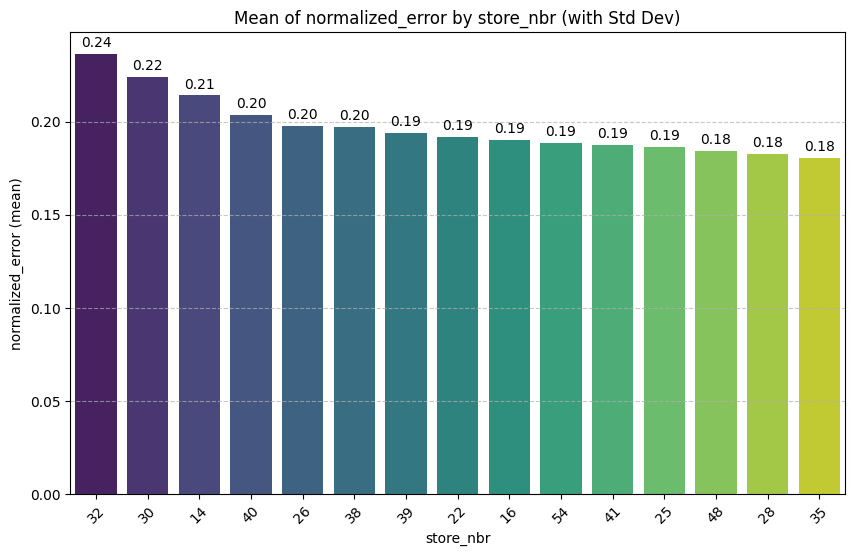

In [69]:
per_store = test_df_error_analysis.groupby('store_nbr').agg({'squared_error': 'mean', 'abs_error': 'mean', 'sales': 'mean', 'error': 'mean'}).reset_index()
per_store['rmse'] = per_store['squared_error']**0.5
per_store['normalized_error'] = per_store['abs_error'] / per_store['sales']
per_store['sales_bin'] = per_store['sales'].apply(lambda x: f'{(x // 300)*300}-{((x // 300)+1)*300}')

plot_categorical_bar(per_store, 'store_nbr', target_col='normalized_error', agg_type='mean', top_k=15, tilt_angle=45)

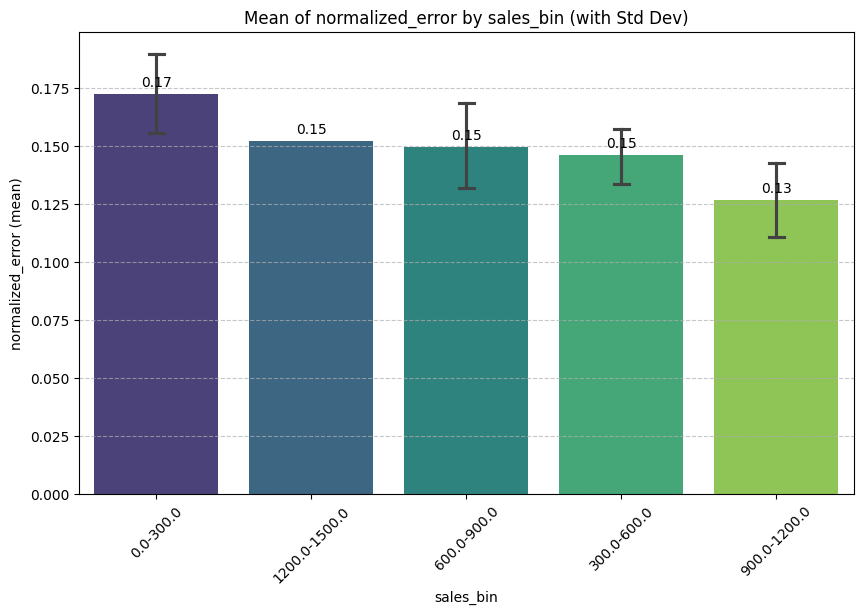

In [70]:
plot_categorical_bar(per_store, 'sales_bin', target_col='normalized_error', agg_type='mean', top_k=15, tilt_angle=45)

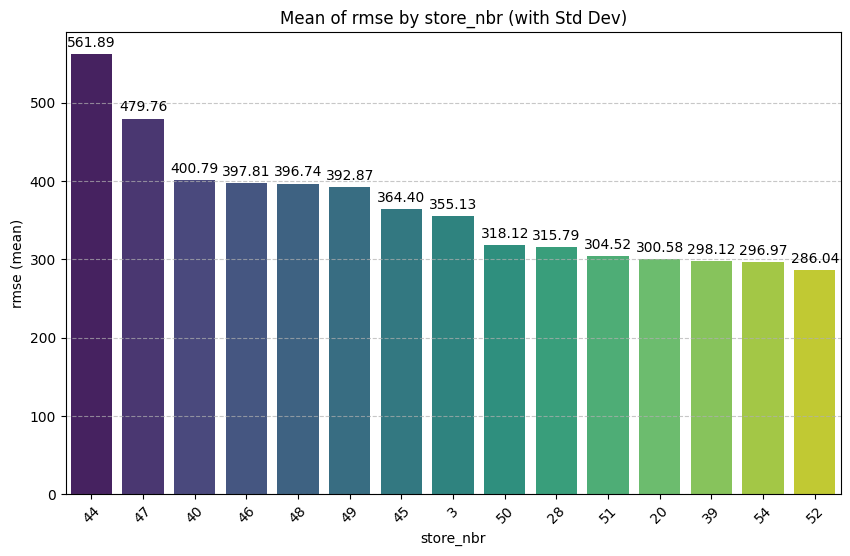

In [71]:
plot_categorical_bar(per_store, 'store_nbr', target_col='rmse', agg_type='mean', top_k=15, tilt_angle=45)

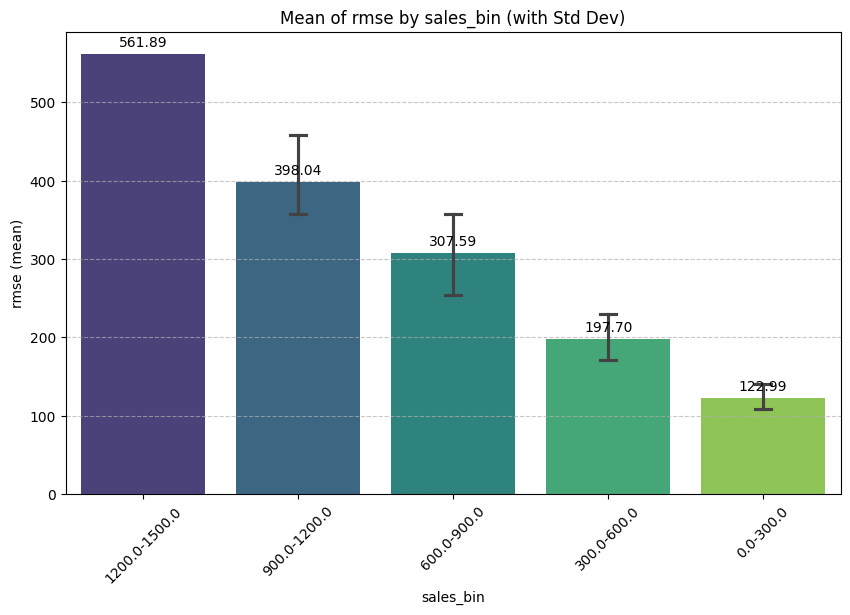

In [72]:
plot_categorical_bar(per_store, 'sales_bin', target_col='rmse', agg_type='mean', top_k=15, tilt_angle=45)

Above analysis suggests several insights:

1. we see a relative stable error across different sales volumes, with a higher relative error in stores with lower sales colume (0-300).
2. Stores with higher sales volume, associated with higher average raw error values (non-normalized per sales).  

## Error Per Item Family

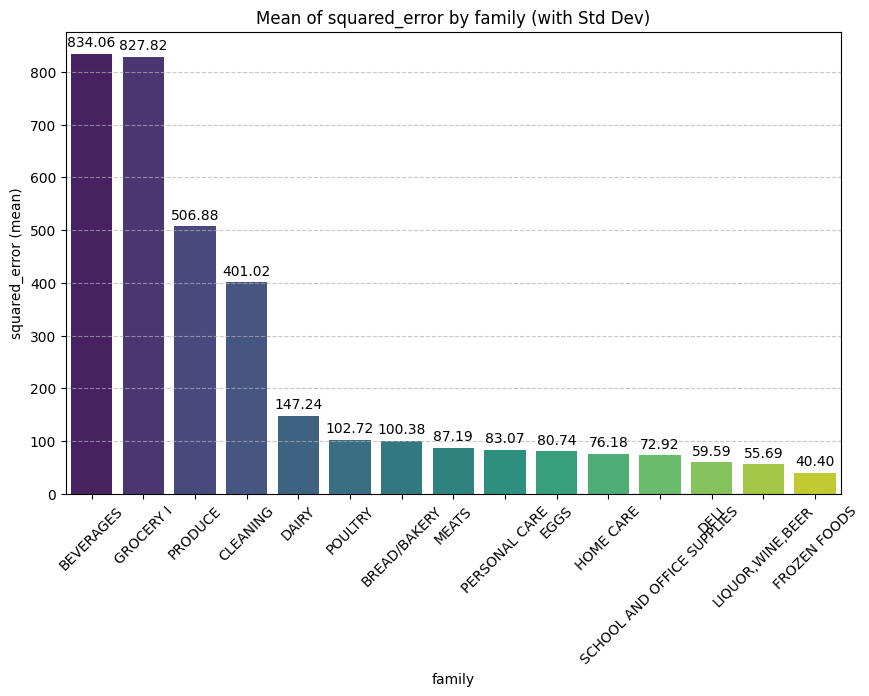

In [75]:
per_family = test_df_error_analysis.groupby('family').agg({'squared_error': 'mean', 'abs_error': 'mean', 'sales': 'mean', 'error': 'mean'}).reset_index()
per_family['squared_error'] = per_family['squared_error']**0.5
per_family['normalized_error'] = per_family['abs_error'] / per_family['sales']
per_family['sales_bin'] = per_family['sales'].apply(lambda x: f'{(x // 300)*300}-{((x // 300)+1)*300}')

plot_categorical_bar(per_family, 'family', target_col='squared_error', agg_type='mean', top_k=15, tilt_angle=45)

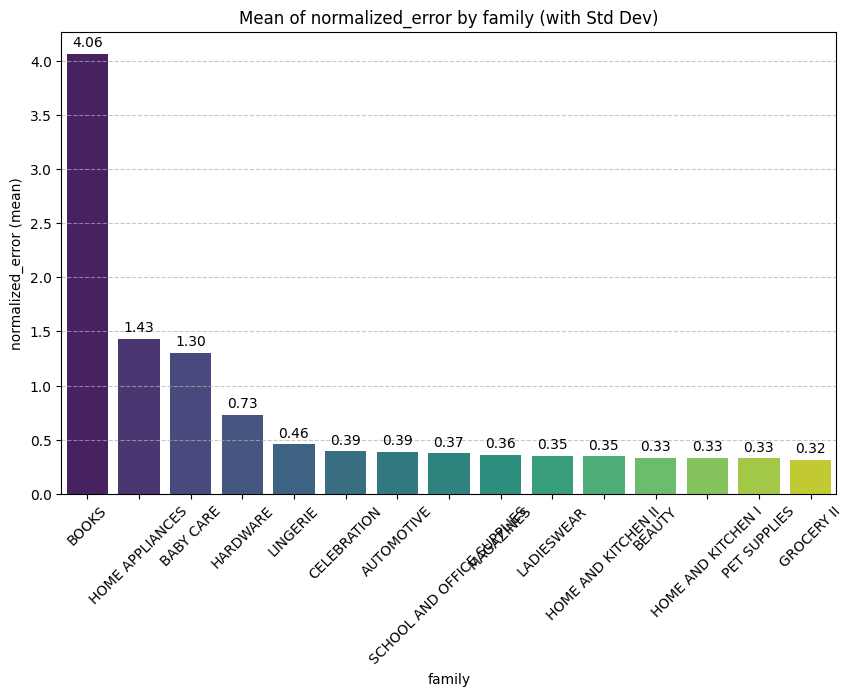

In [76]:
plot_categorical_bar(per_family, 'family', target_col='normalized_error', agg_type='mean', top_k=15, tilt_angle=45)

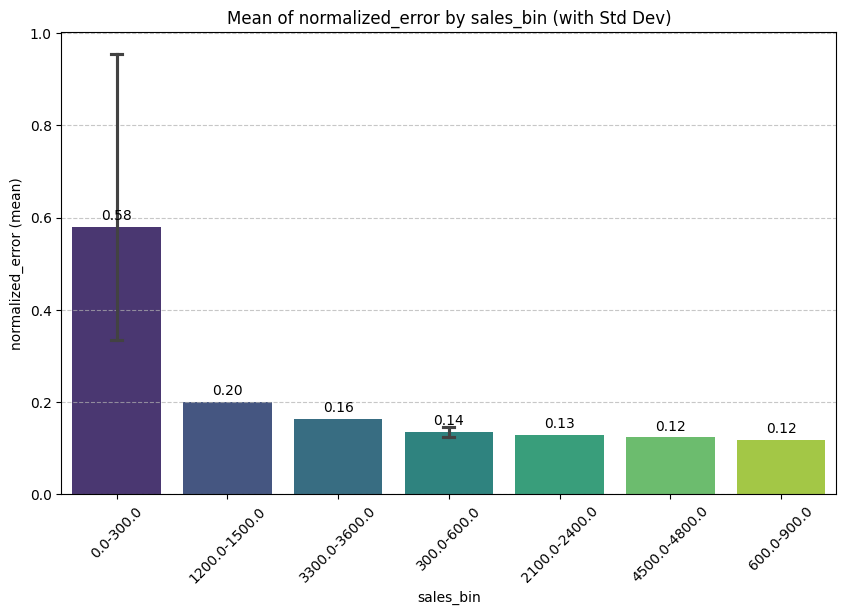

In [77]:
plot_categorical_bar(per_family, 'sales_bin', target_col='normalized_error', agg_type='mean', top_k=15, tilt_angle=45)

## 📉 Error Analysis Insights

#### 1. Performance by Store Scale

* **Scale-Dependent Relative Error:** The analysis reveals a relatively stable error rate across most sales volumes. However, we observe **higher relative error (RMSLE)** in lower-volume stores (0–300 units). This suggests that "noisier" demand patterns in smaller stores make them more difficult to predict than high-volume locations.
* **Absolute Error Scaling:** Conversely, stores with higher sales volumes are associated with higher **absolute (raw) error** values. While the model is more accurate in percentage terms for these stores, the sheer magnitude of their sales leads to larger nominal discrepancies.

#### 2. Performance by Product Family

* **Low-Volume Underperformance:** Normalizing the error relative to sales confirms that **niche or low-volume item families** are underperforming. The model struggles to capture the sparse signals characteristic of these categories.
* **Volume-Error Correlation:** Similar to the store analysis, we observe that as the sales volume of a family increases, the average raw error increases as well. This indicates a **heteroscedastic** relationship where the variance of our residuals grows with the scale of the target.


---


# 📊 Project Summary: Store Sales Forecasting

This project focuses on forecasting sales for stores in Ecuador using historical data from **2013 to 2017**. By combining deep exploratory analysis with gradient-boosted models, we developed a pipeline capable of capturing complex retail trends.

### 🔍 Key Insights from EDA

* **Feature Importance:** Store IDs, product families, and time-series components (seasonality/lags) emerged as the most predictive features.
* **Anomaly Handling:** We identified a significant shift in purchasing behavior following the **2016 earthquake**. To maintain model stability, data from this period was removed to prevent the model from learning "crisis-induced" patterns that don't apply to normal operations.
* **Operational Logic:** Analysis confirmed that stores are closed on **January 1st and December 25th**. Accounting for these zero-sale days significantly reduced our error rate.

### 🛠️ Modeling Strategy

* **Algorithm Selection:** After benchmarking against a Linear Regression baseline, **XGBoost** was selected for its superior ability to capture non-linear relationships and store-specific trends.
* **Target Transformation:** To align with the **RMSLE** evaluation metric, we applied a **log transformation** () to the target variable. This shifted the model's focus from absolute differences to **relative percentage errors**, ensuring that "small" and "large" stores are weighted fairly.

### 🏆 Final Results

Through iterative **hyperparameter tuning** and **feature selection**, the model achieved a final evaluation score of:
**RMSLE = 0.381**